# Balsa

**Balsa**, based on **Teak**.. 

> 500 batches of 18 entries each.
> only 200 epochs
> different data than teak

#### Imports

In [1]:
import tensorflow as tf
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
import glob
import sys
import io

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

/Users/andrew/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Log ID

In [6]:
# log_random_serial_number = '{}'.format(np.random.randint(100000,999999))
# print(log_random_serial_number)
933346

933346

In [5]:
def log_dir(log_random_serial_number):
    master_log_path = '../../../logs/'
    log_num = len(glob.glob(master_log_path + log_random_serial_number + '*'))
    
    direc = master_log_path + log_random_serial_number
    if log_num > 0:
        # assumes less than 26 runs per graph
        direc += chr(ord('@') + log_num)
    return direc
log_direc = log_dir('933346')
print(log_direc)

../../../logs/933346


##### Flags

In [7]:
flags = tf.app.flags

# flag 'f' prevents an error due to using flags in jupyter notebook
#https://github.com/tensorflow/tensorflow/issues/17702#issuecomment-387335646
flags.DEFINE_string('f', '', 'kernel')

In [8]:
# Data parameters
flags.DEFINE_float("testing_data_percentage", 0.10,"Percentage of the data to use for testing. (default: 0.10)")
flags.DEFINE_string('data_path', '../../../data/wrapped_10000_moderate_gaussian_noise_A.bz2', "Data source for training and testing")

In [9]:
# training parameters
flags.DEFINE_integer('num_epochs', 200, "Number of training epochs (default: 200)")
flags.DEFINE_float('keep_prob', 0.50, "Dropout probability (default: 0.50)")
flags.DEFINE_float('learning_rate', 0.0001, "Learning rate (default: 0.001)")

In [10]:
FLAGS = tf.flags.FLAGS
# FLAGS(sys.argv)
# print("\nParameters:")
# for attr, value in sorted(FLAGS.__flags.items()):
#     print("{}={}".format(attr.upper(), value))
# print("")

#### Load, scale, split data

In [11]:
def load_data(data_path, output_col = 'tau'):
    """Loads data from csv. Returns inputs and outputs as DataFrames"""
    df = pd.read_csv(data_path)
    
    inputs = df.drop(output_col, axis = 1)
    outputs = df[[output_col]]
    
    return [inputs, outputs]

In [12]:
data = load_data(FLAGS.data_path)

In [13]:
def scale_data(data):
    """Returns scaled inputs & outputs, and their scalers."""
    input_scaler  = MinMaxScaler(feature_range = (0,1))
    output_scaler = MinMaxScaler(feature_range = (0,1))
    
    scaled_input  =  input_scaler.fit_transform(data[0])
    scaled_output = output_scaler.fit_transform(data[1])
    
    return [scaled_input, scaled_output, input_scaler, output_scaler]

In [14]:
scaled_input, scaled_output, input_scaler, output_scaler = scale_data(data)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(scaled_input, scaled_output,
                                                    test_size = FLAGS.testing_data_percentage,
                                                    random_state = np.random.seed(int(time.time())))

In [16]:
X_train.shape

(9000, 1024)

In [17]:
number_of_inputs  = scaled_input.shape[1]
number_of_outputs = scaled_output.shape[1]

In [18]:
layer_1_nodes = 256
layer_2_nodes = 128
layer_3_nodes = 64

In [19]:
tf.reset_default_graph()

In [20]:
with tf.variable_scope('input_X'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))
    
with tf.variable_scope('input_y'):
    y  = tf.placeholder(tf.float32, shape = (None, 1))
    
with tf.variable_scope('keep'):
    keep_prob = tf.placeholder(tf.float32)
    
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes], 
                              initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.leaky_relu(tf.matmul(X, weights) + biases)

with tf.variable_scope('dropout_12'):
    drop_out_12 = tf.nn.dropout(layer_1_output, keep_prob)     
      
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(drop_out_12, weights) + biases)
    
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)
    
with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_3_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)
    
with tf.variable_scope('cost'):

    cost = tf.reduce_mean(tf.squared_difference(prediction, y))

with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.histogram('cost', cost)
    tf.summary.histogram('predictions', prediction)
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()

In [21]:
saver = tf.train.Saver()

 epoch:    0 batch: 499
 epoch:    1 batch: 499st: 0.0830278546
 epoch:    2 batch: 499st: 0.0866966695
 epoch:    3 batch: 499st: 0.0850287303
 epoch:    4 batch: 499st: 0.0894910917
 epoch:    4 testing_cost: 0.0907917768

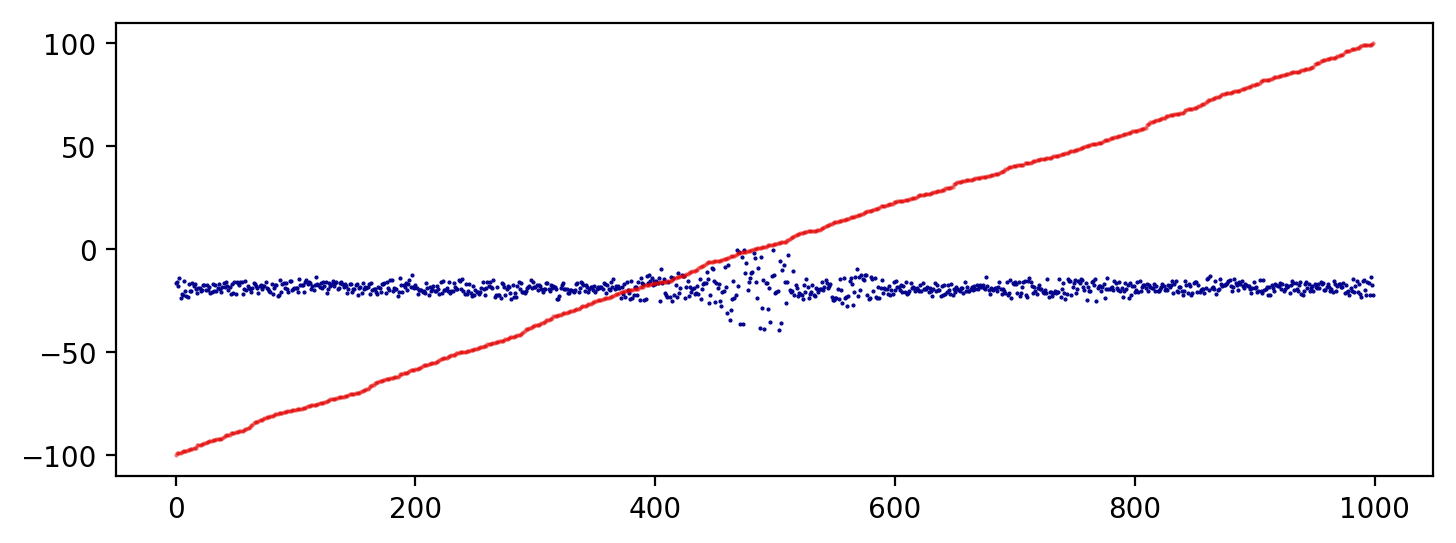

 epoch:    5 batch: 499
 epoch:    6 batch: 499st: 0.0836712793
 epoch:    7 batch: 499st: 0.0895032361
 epoch:    8 batch: 499st: 0.0853833184
 epoch:    9 batch: 499st: 0.0946853831
 epoch:    9 testing_cost: 0.0838621184

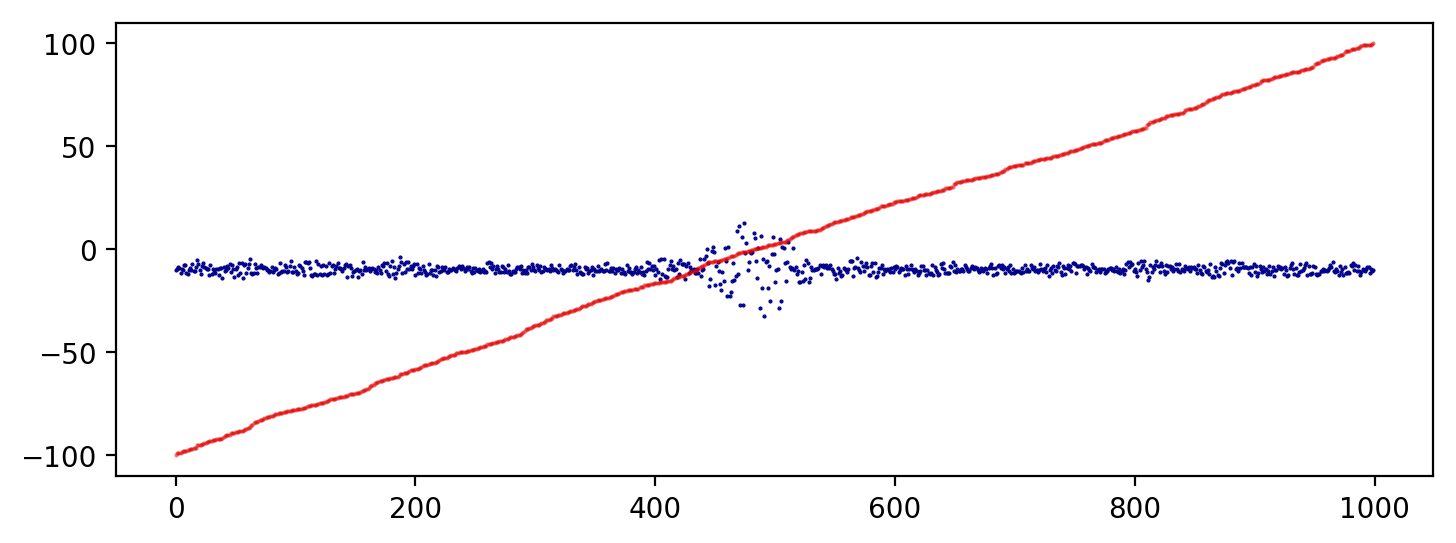

 epoch:   10 batch: 499
 epoch:   11 batch: 499st: 0.0920181423
 epoch:   12 batch: 499st: 0.0847847760
 epoch:   13 batch: 499st: 0.0830141157
 epoch:   14 batch: 499st: 0.0879342780
 epoch:   14 testing_cost: 0.0858940929

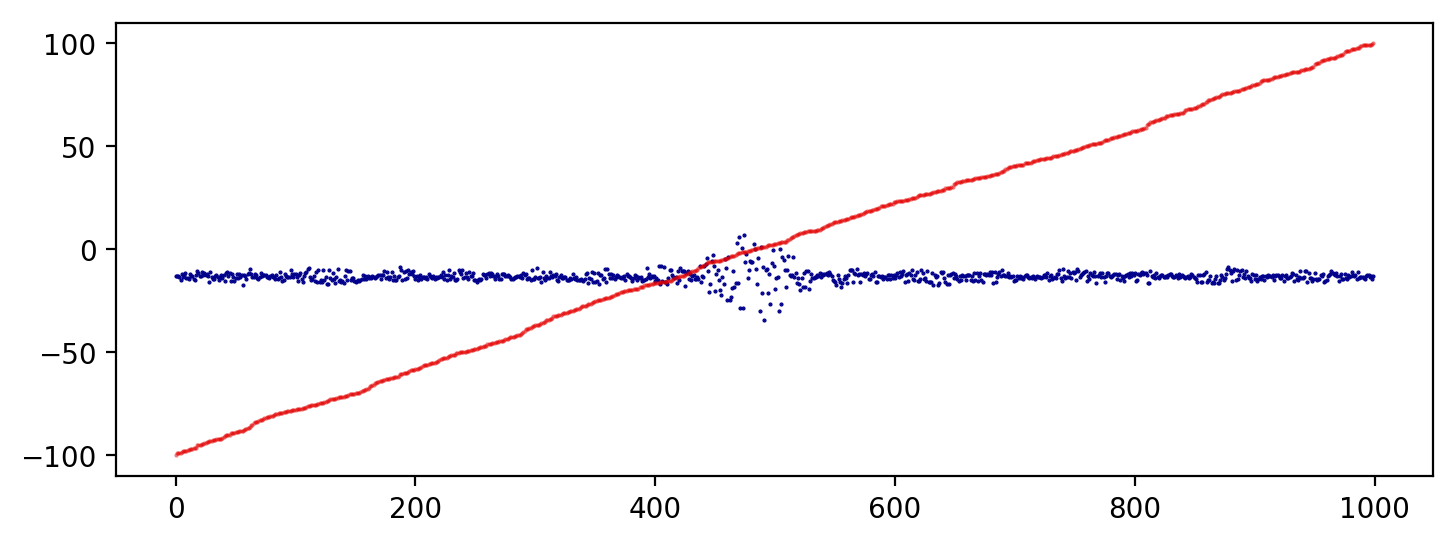

 epoch:   15 batch: 499
 epoch:   16 batch: 499st: 0.0840465873
 epoch:   17 batch: 499st: 0.0844131857
 epoch:   18 batch: 499st: 0.0833863094
 epoch:   19 batch: 499st: 0.0808855146
 epoch:   19 testing_cost: 0.0815504268

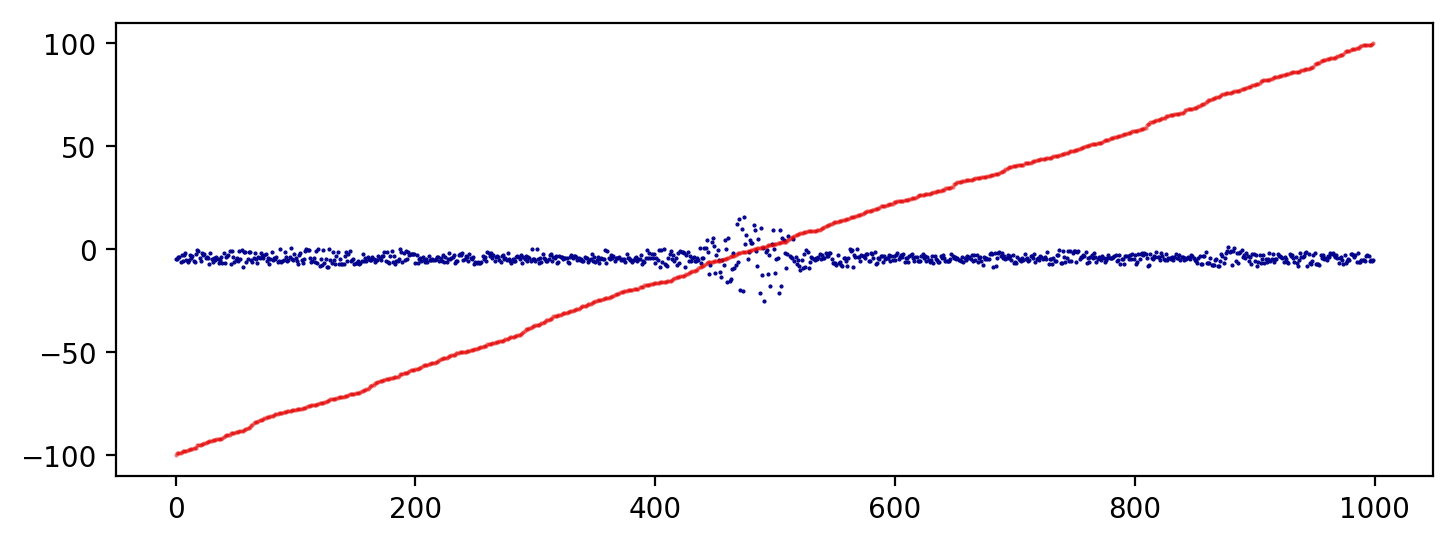

 epoch:   20 batch: 499
 epoch:   21 batch: 499st: 0.0842761248
 epoch:   22 batch: 499st: 0.0814592168
 epoch:   23 batch: 499st: 0.0831400231
 epoch:   24 batch: 499st: 0.0878522098
 epoch:   24 testing_cost: 0.0842740908

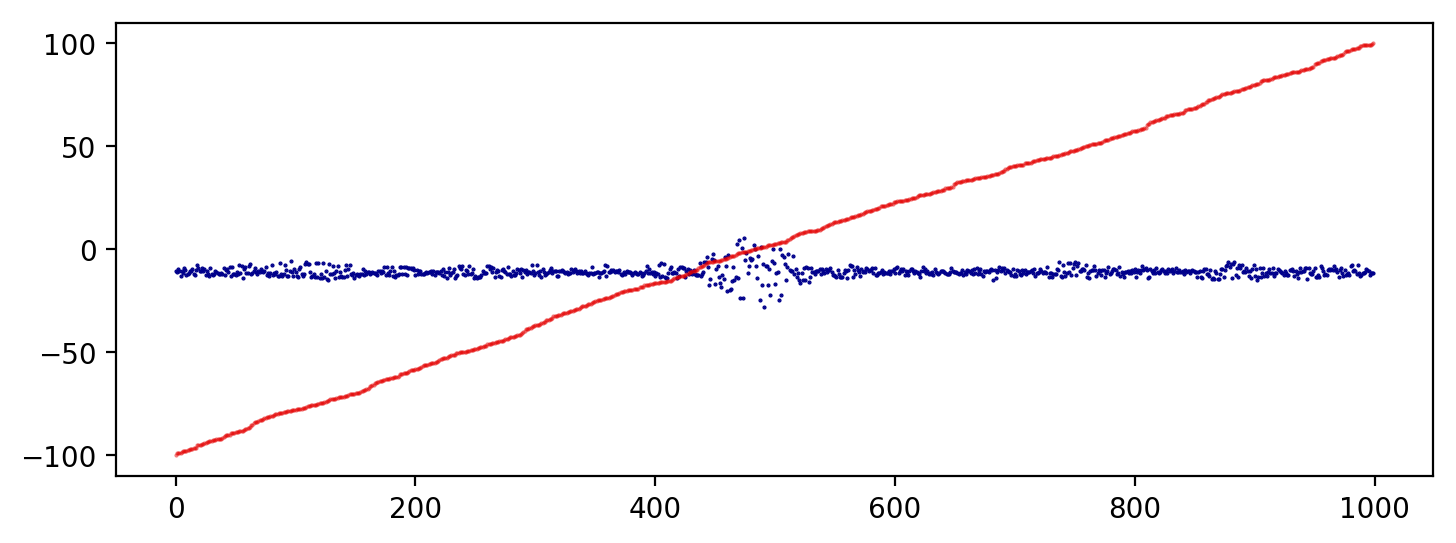

 epoch:   25 batch: 499
 epoch:   26 batch: 499st: 0.0823801607
 epoch:   27 batch: 499st: 0.0867072642
 epoch:   28 batch: 499st: 0.0825749338
 epoch:   29 batch: 499st: 0.0844913051
 epoch:   29 testing_cost: 0.0858796015

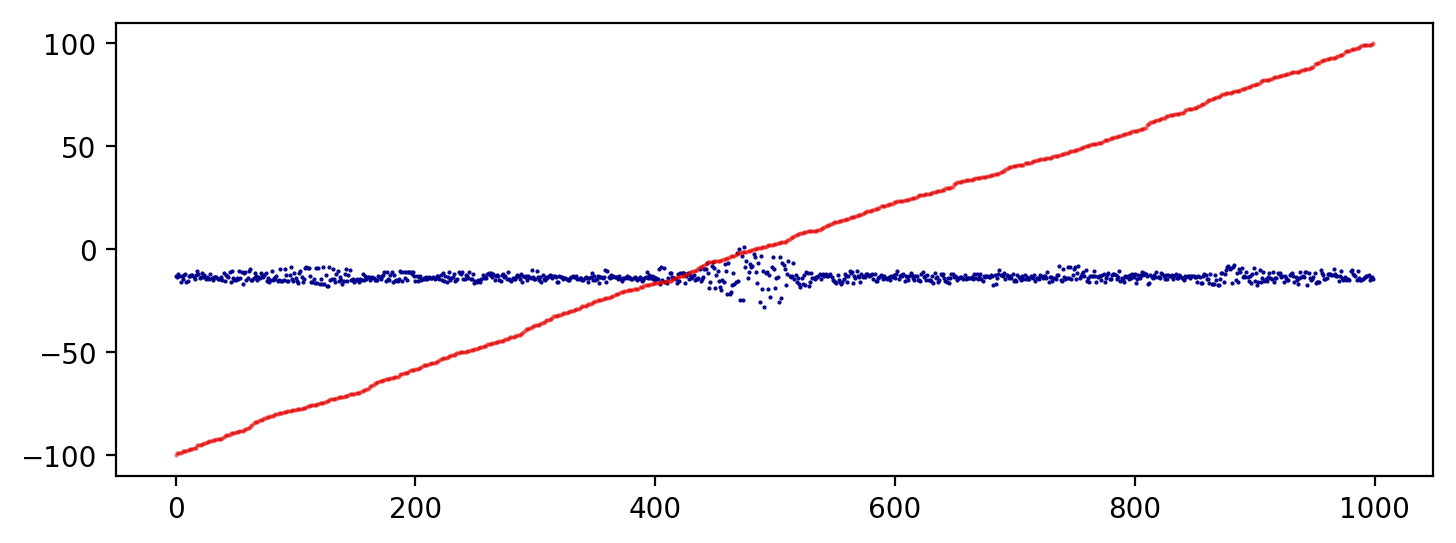

 epoch:   30 batch: 499
 epoch:   31 batch: 499st: 0.0849886313
 epoch:   32 batch: 499st: 0.0809790045
 epoch:   33 batch: 499st: 0.0805997327
 epoch:   34 batch: 499st: 0.0857687220
 epoch:   34 testing_cost: 0.0825695470

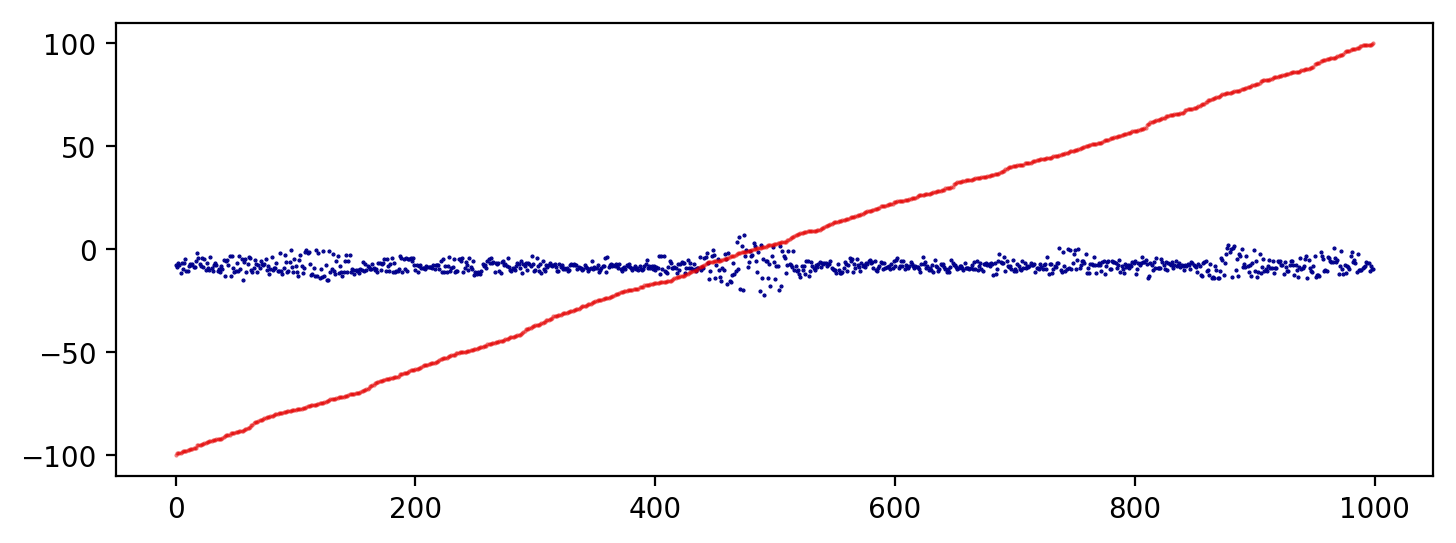

 epoch:   35 batch: 499
 epoch:   36 batch: 499st: 0.0804835036
 epoch:   37 batch: 499st: 0.0805896297
 epoch:   38 batch: 499st: 0.0812278464
 epoch:   39 batch: 499st: 0.0820542127
 epoch:   39 testing_cost: 0.0839919671

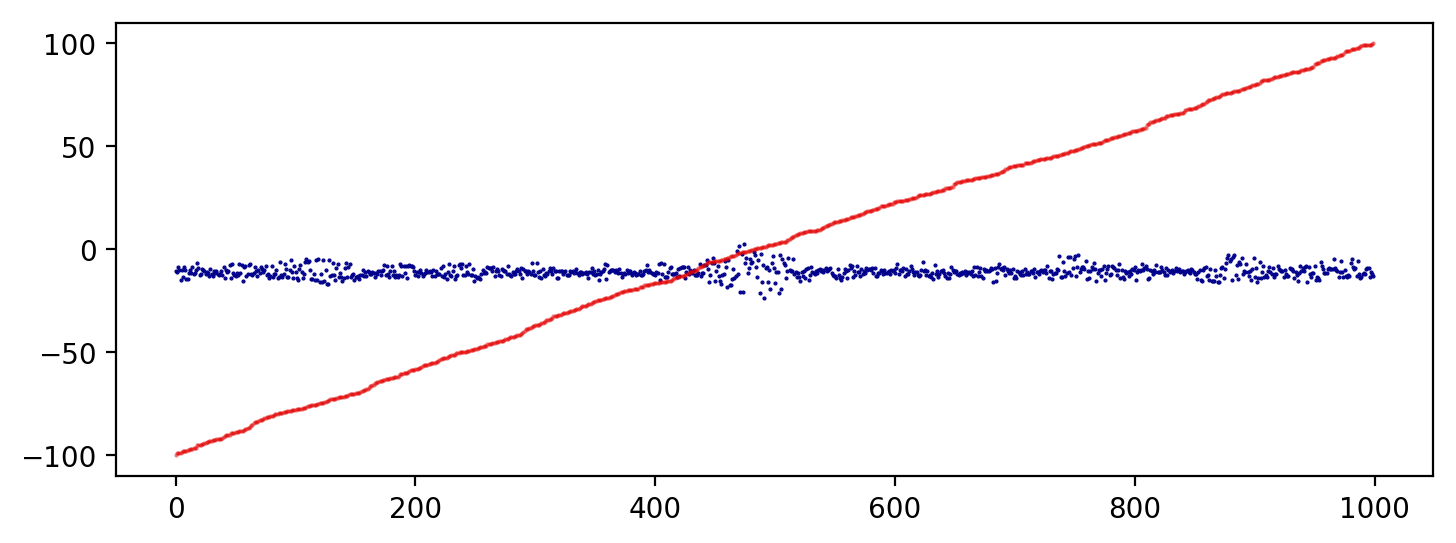

 epoch:   40 batch: 499
 epoch:   41 batch: 499st: 0.0830733404
 epoch:   42 batch: 499st: 0.0818198547
 epoch:   43 batch: 499st: 0.0822107643
 epoch:   44 batch: 499st: 0.0819610581
 epoch:   44 testing_cost: 0.0806564614

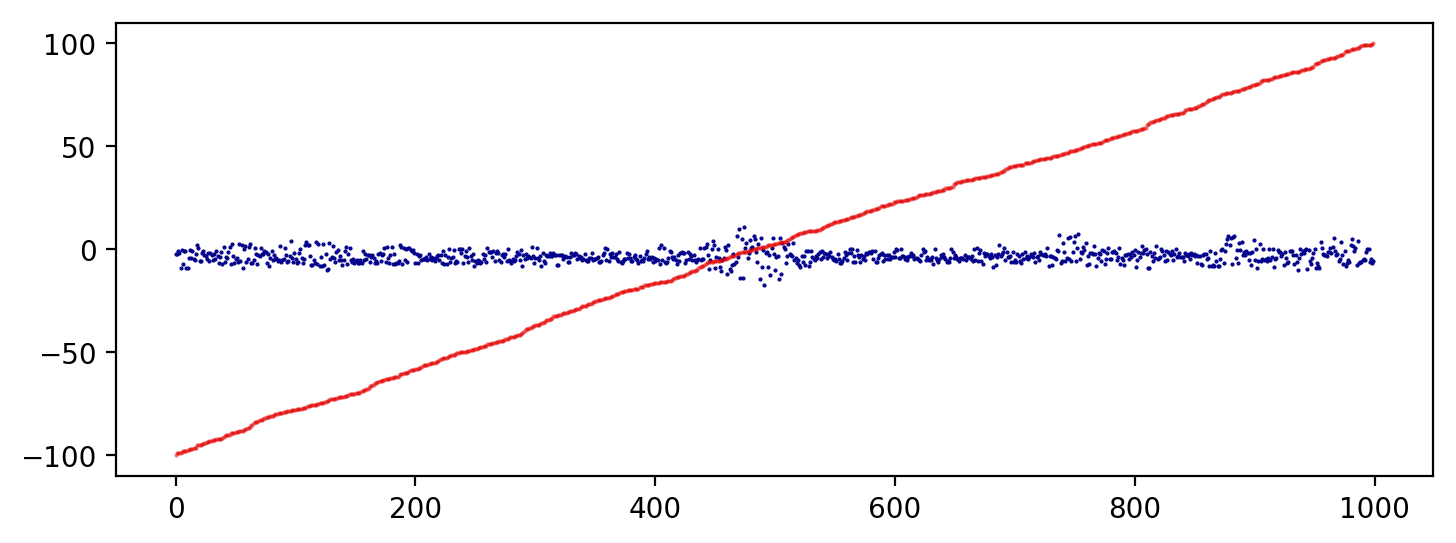

 epoch:   45 batch: 499
 epoch:   46 batch: 499st: 0.0805783719
 epoch:   47 batch: 499st: 0.0811581388
 epoch:   48 batch: 499st: 0.0809301808
 epoch:   49 batch: 499st: 0.0815689862
 epoch:   49 testing_cost: 0.0824244618

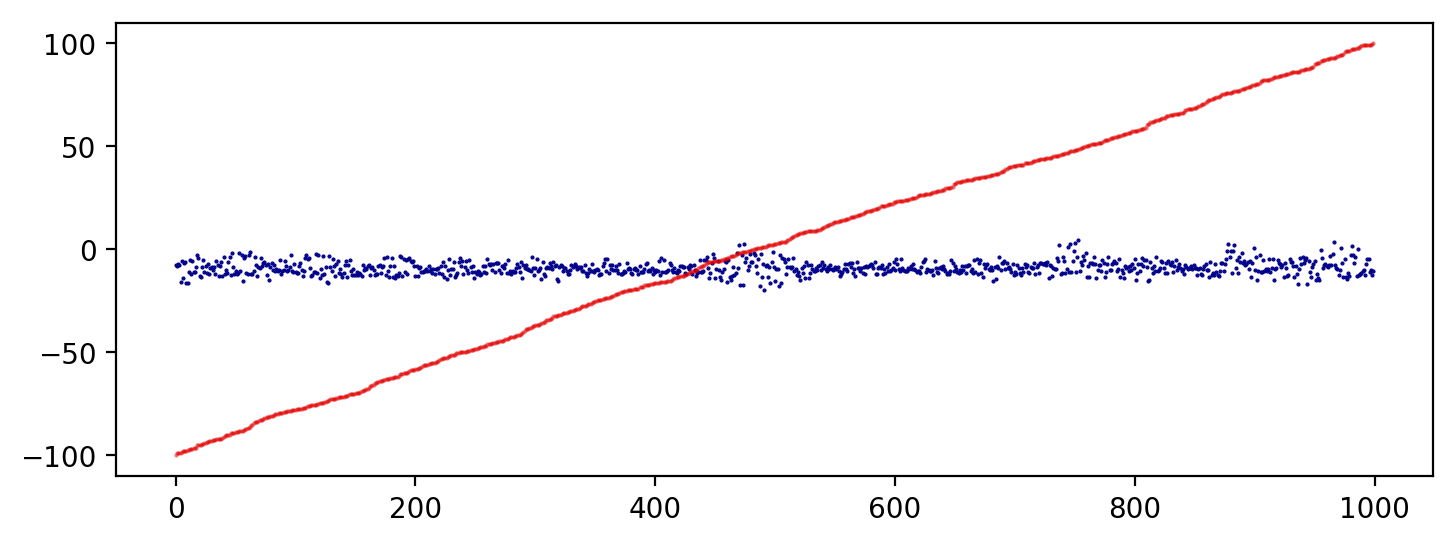

 epoch:   50 batch: 499
 epoch:   51 batch: 499st: 0.0839919448
 epoch:   52 batch: 499st: 0.0803354830
 epoch:   53 batch: 499st: 0.0804507583
 epoch:   54 batch: 499st: 0.0802210867
 epoch:   54 testing_cost: 0.0808570534

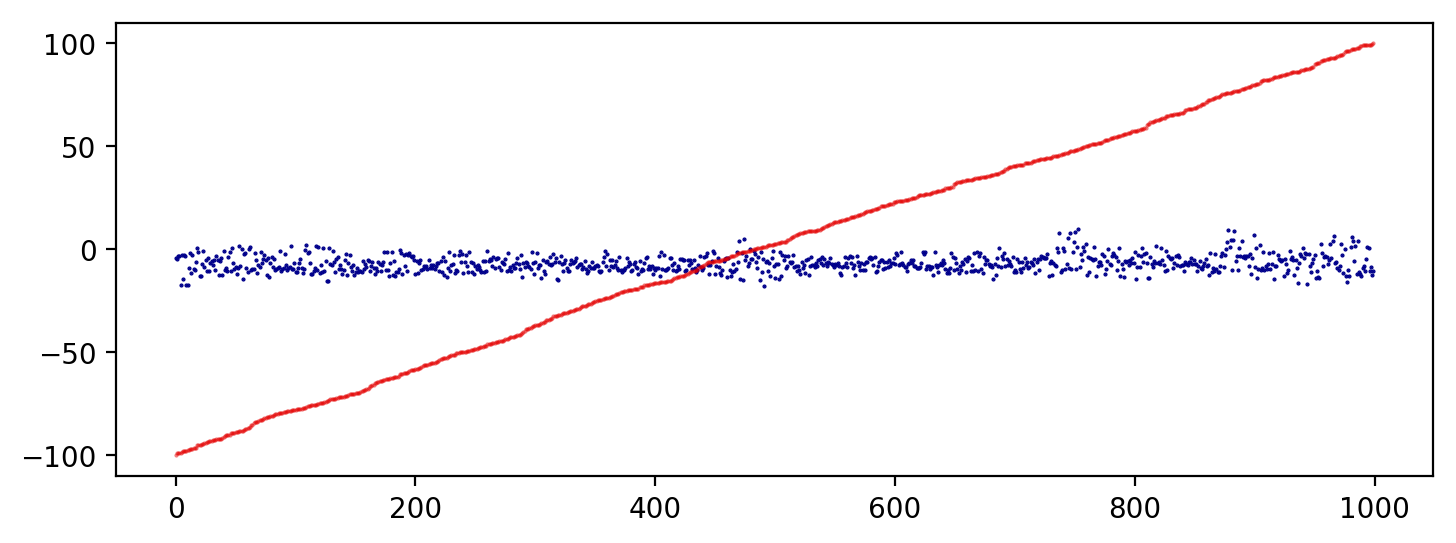

 epoch:   55 batch: 499
 epoch:   56 batch: 499st: 0.0798718855
 epoch:   57 batch: 499st: 0.0803031027
 epoch:   58 batch: 499st: 0.0790255293
 epoch:   59 batch: 499st: 0.0804613158
 epoch:   59 testing_cost: 0.0779943690

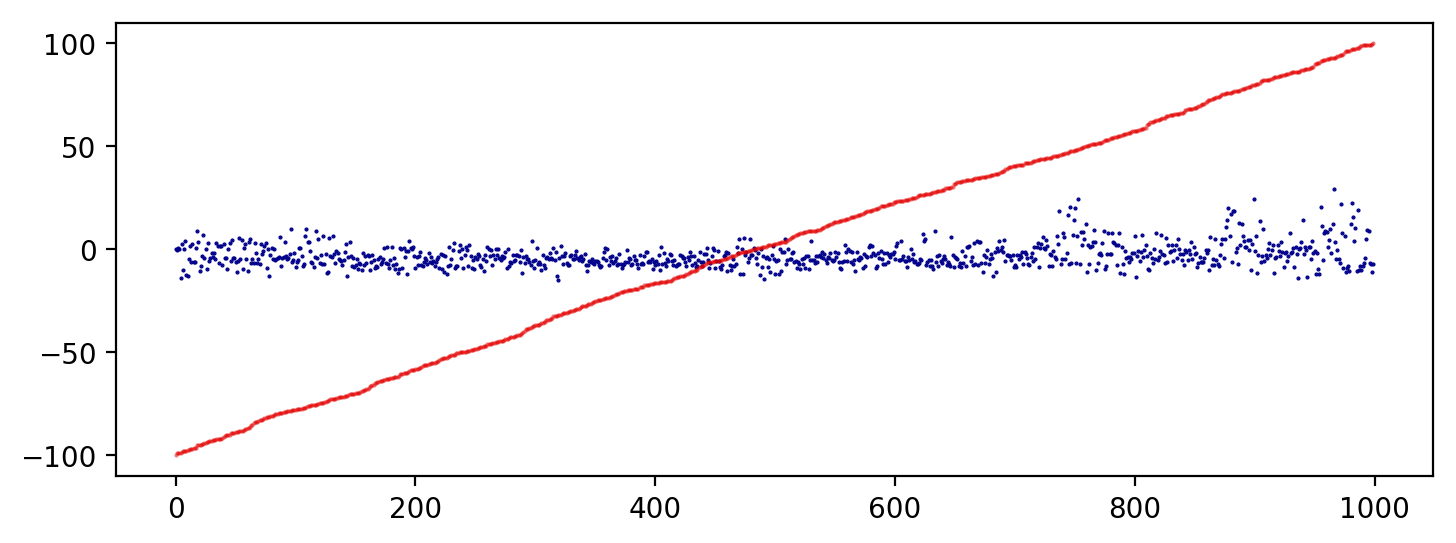

 epoch:   60 batch: 499
 epoch:   61 batch: 499st: 0.0782044977
 epoch:   62 batch: 499st: 0.0768363029
 epoch:   63 batch: 499st: 0.0801258609
 epoch:   64 batch: 499st: 0.0804089084
 epoch:   64 testing_cost: 0.0761420578

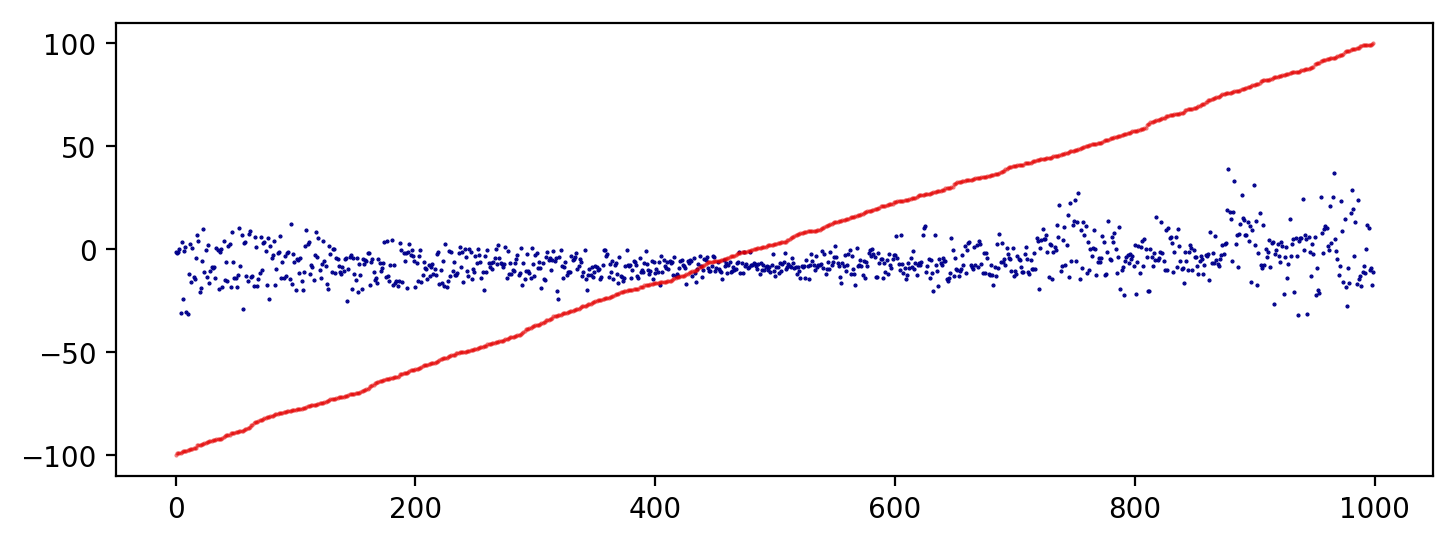

 epoch:   65 batch: 499
 epoch:   66 batch: 499st: 0.0777140856
 epoch:   67 batch: 499st: 0.0886462256
 epoch:   68 batch: 499st: 0.0734454840
 epoch:   69 batch: 499st: 0.0752556026
 epoch:   69 testing_cost: 0.0774616674

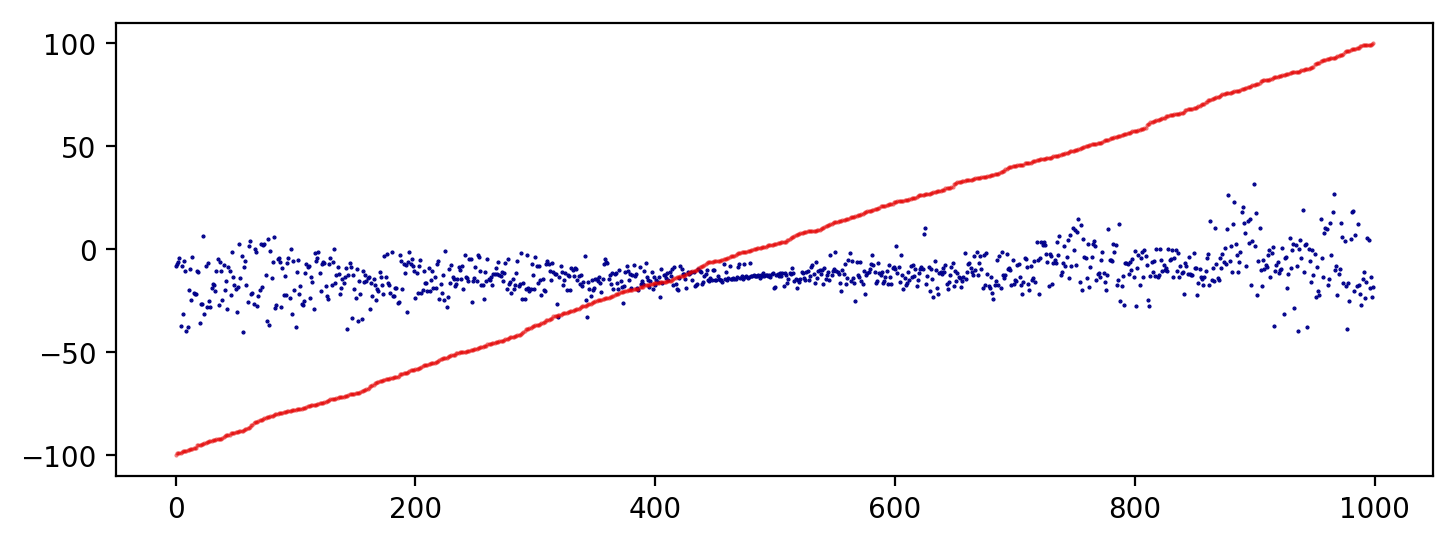

 epoch:   70 batch: 499
 epoch:   71 batch: 499st: 0.0734805018
 epoch:   72 batch: 499st: 0.0727803633
 epoch:   73 batch: 499st: 0.0705614612
 epoch:   74 batch: 499st: 0.0734984577
 epoch:   74 testing_cost: 0.0713788420

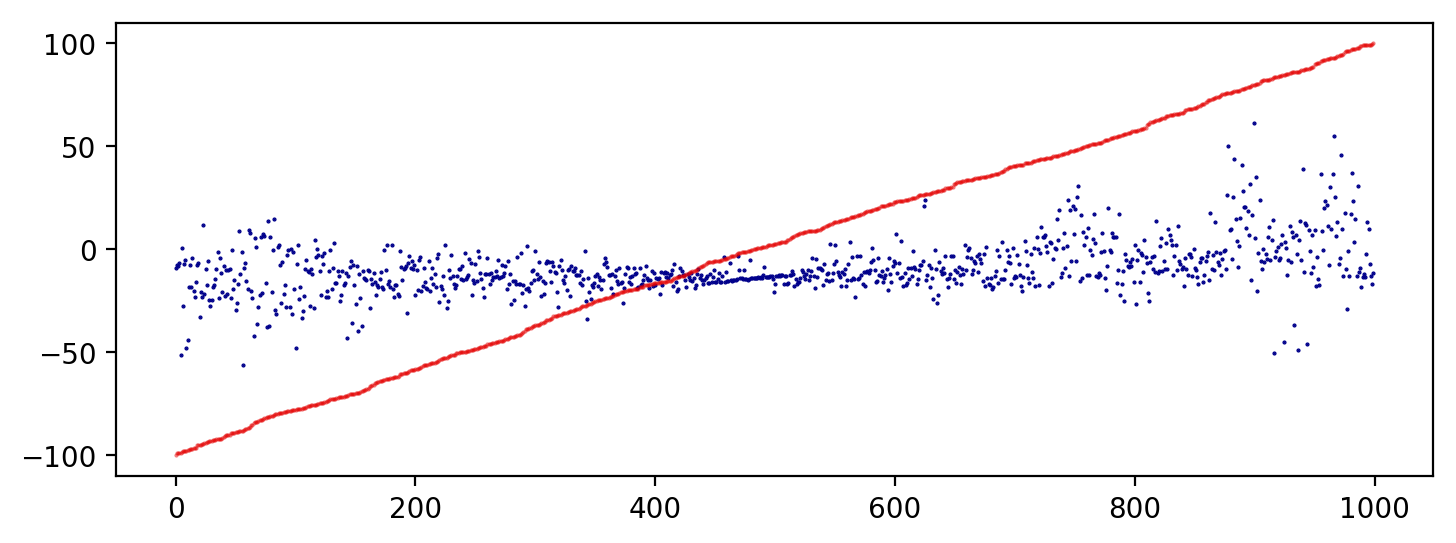

 epoch:   75 batch: 499
 epoch:   76 batch: 499st: 0.0773961321
 epoch:   77 batch: 499st: 0.0695244968
 epoch:   78 batch: 499st: 0.0663895383
 epoch:   79 batch: 499st: 0.0686592087
 epoch:   79 testing_cost: 0.0637142286

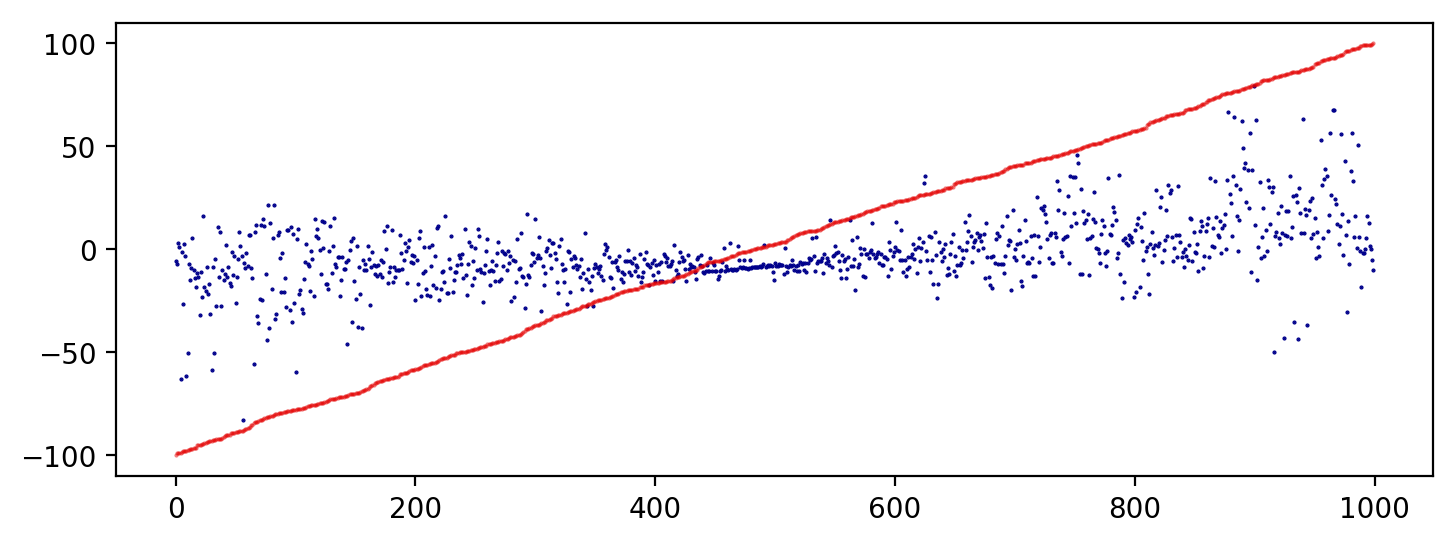

 epoch:   80 batch: 499
 epoch:   81 batch: 499st: 0.0673271045
 epoch:   82 batch: 499st: 0.0660561994
 epoch:   83 batch: 499st: 0.0625124723
 epoch:   84 batch: 499st: 0.0615224689
 epoch:   84 testing_cost: 0.0563899390

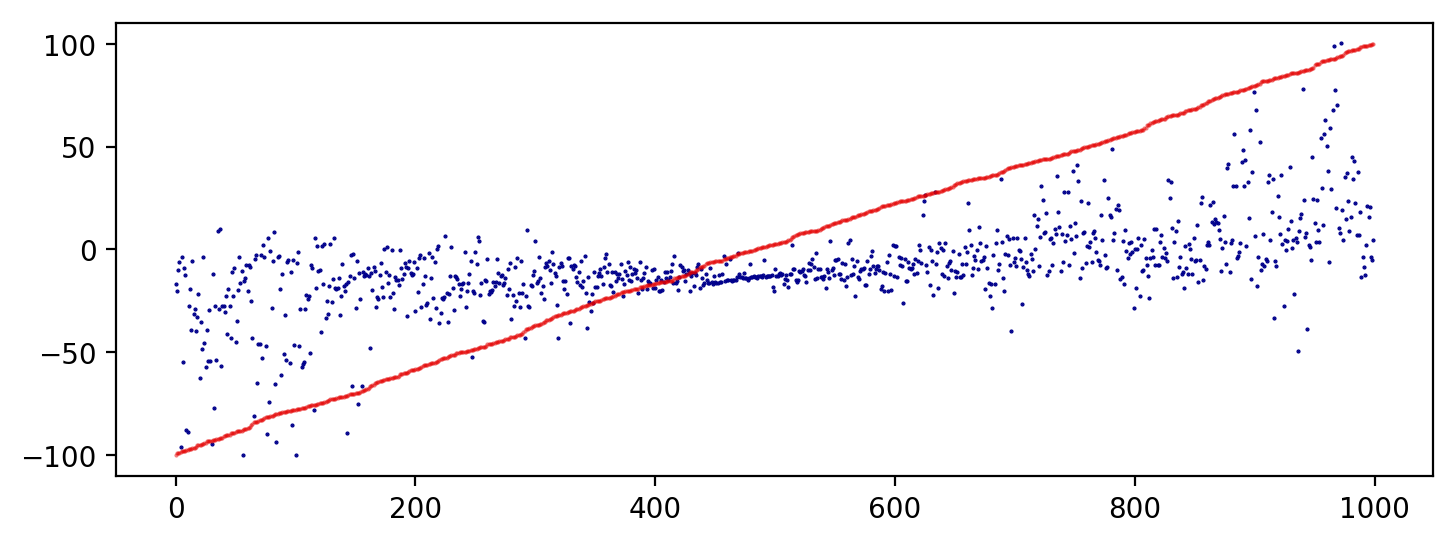

 epoch:   85 batch: 499
 epoch:   86 batch: 499st: 0.0533801652
 epoch:   87 batch: 499st: 0.0513726175
 epoch:   88 batch: 499st: 0.0446605757
 epoch:   89 batch: 499st: 0.0454717241
 epoch:   89 testing_cost: 0.0452650413

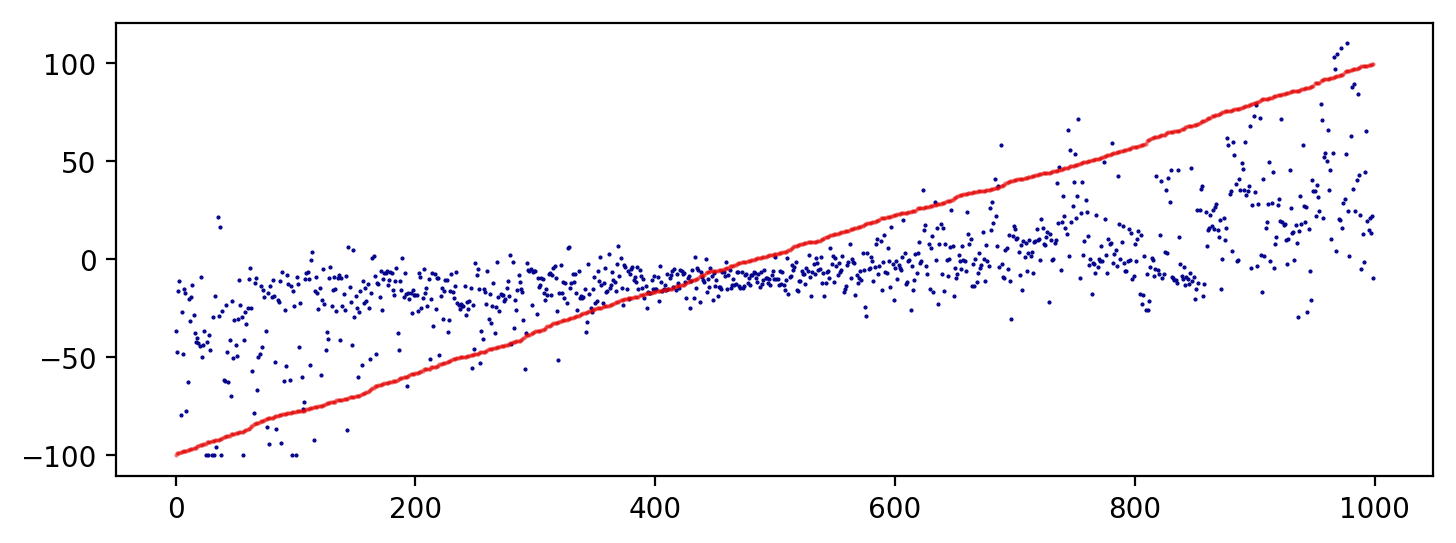

 epoch:   90 batch: 499
 epoch:   91 batch: 499st: 0.0389152206
 epoch:   92 batch: 499st: 0.0361099280
 epoch:   93 batch: 499st: 0.0369921736
 epoch:   94 batch: 499st: 0.0327177420
 epoch:   94 testing_cost: 0.0354286134

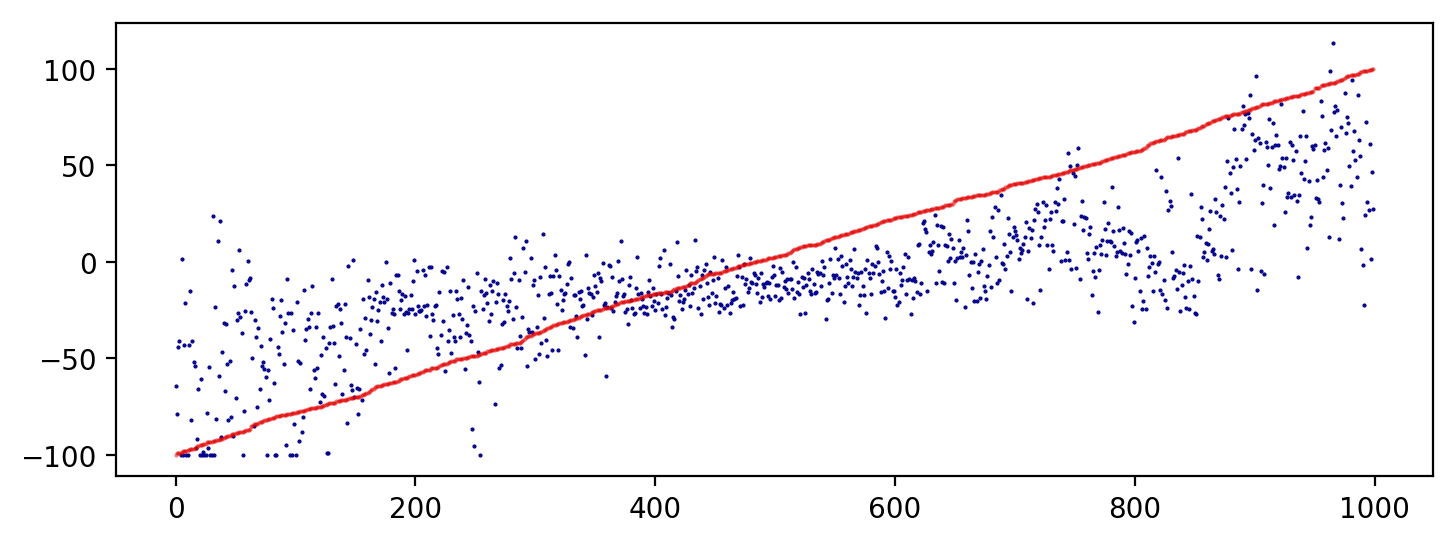

 epoch:   95 batch: 499
 epoch:   96 batch: 499st: 0.0296661854
 epoch:   97 batch: 499st: 0.0250341184
 epoch:   98 batch: 499st: 0.0240705144
 epoch:   99 batch: 499st: 0.0213651545
 epoch:   99 testing_cost: 0.0225391816

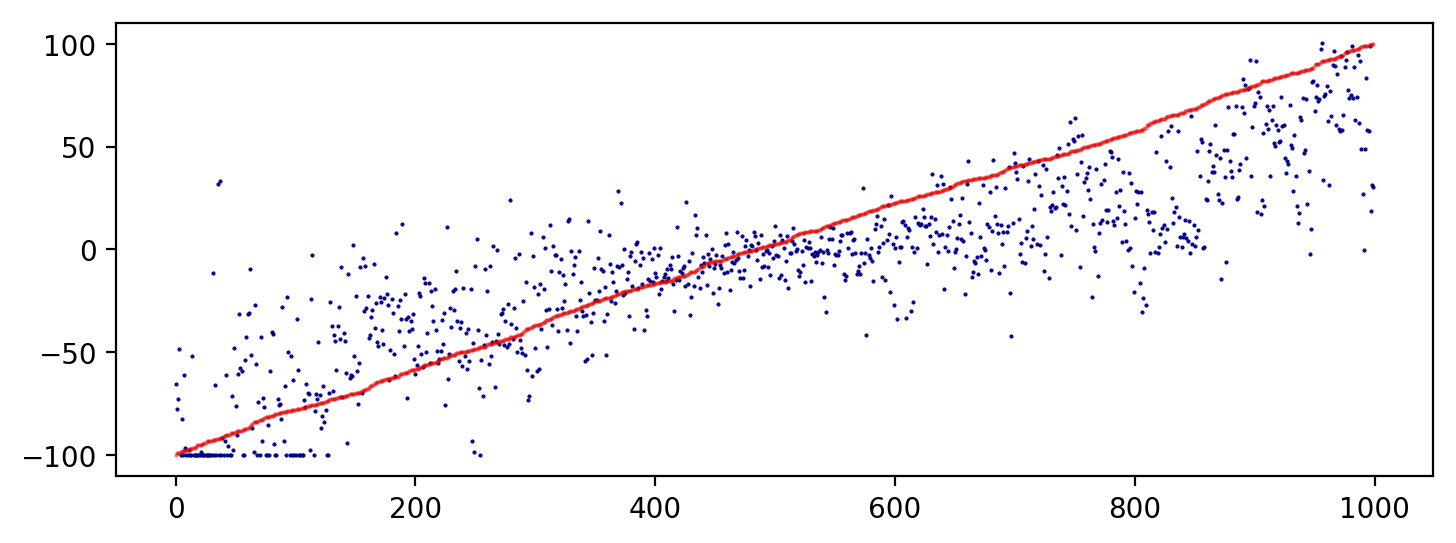

 epoch:  100 batch: 499
 epoch:  101 batch: 499st: 0.0224463269
 epoch:  102 batch: 499st: 0.0180580486
 epoch:  103 batch: 499st: 0.0189361237
 epoch:  104 batch: 499st: 0.0144698275
 epoch:  104 testing_cost: 0.0173352491

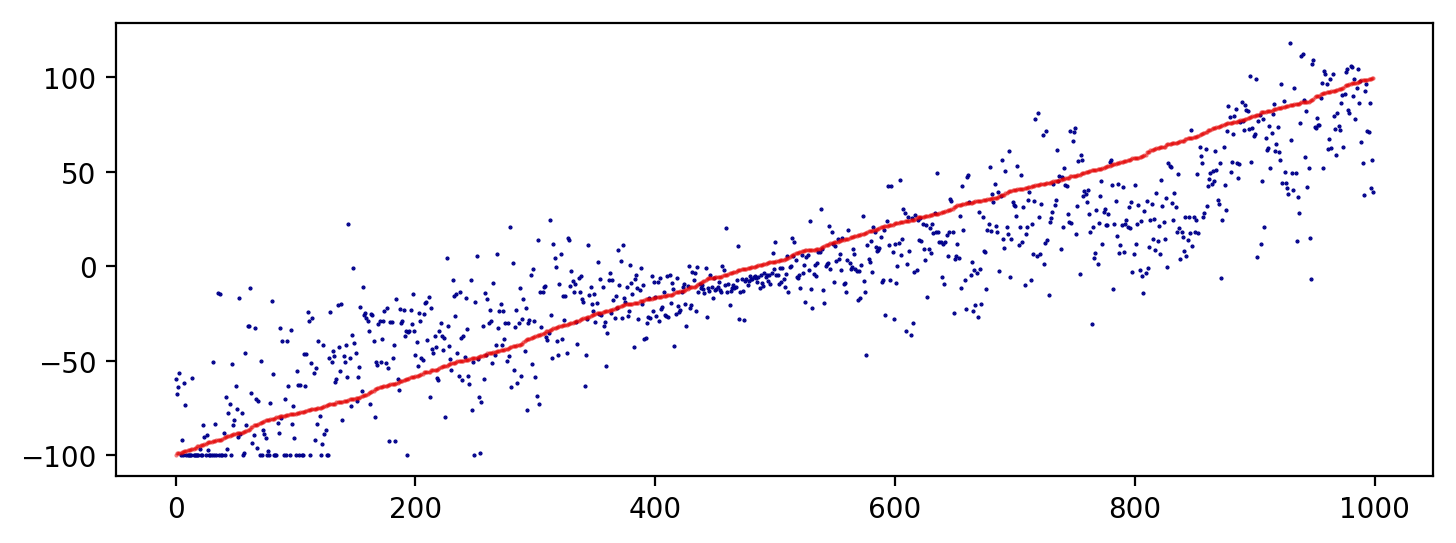

 epoch:  105 batch: 499
 epoch:  106 batch: 499st: 0.0182479881
 epoch:  107 batch: 499st: 0.0147457737
 epoch:  108 batch: 499st: 0.0138790542
 epoch:  109 batch: 499st: 0.0131518887
 epoch:  109 testing_cost: 0.0119101750

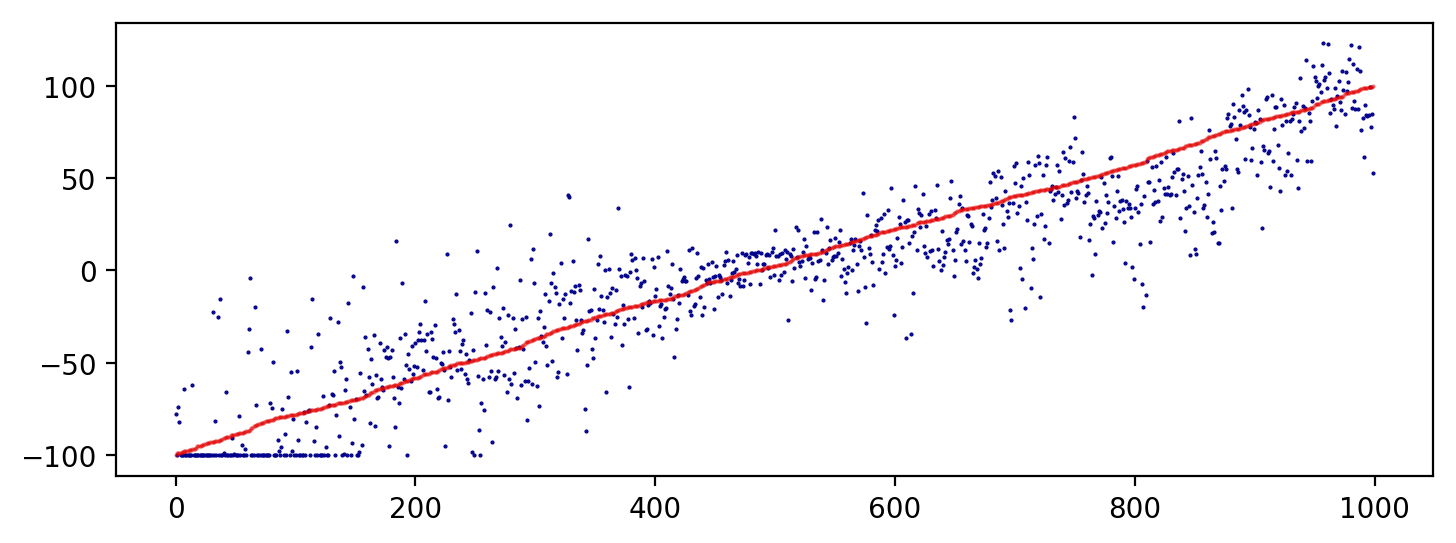

 epoch:  110 batch: 499
 epoch:  111 batch: 499st: 0.0110672377
 epoch:  112 batch: 499st: 0.0106988419
 epoch:  113 batch: 499st: 0.0124397594
 epoch:  114 batch: 499st: 0.0104178432
 epoch:  114 testing_cost: 0.0116633037

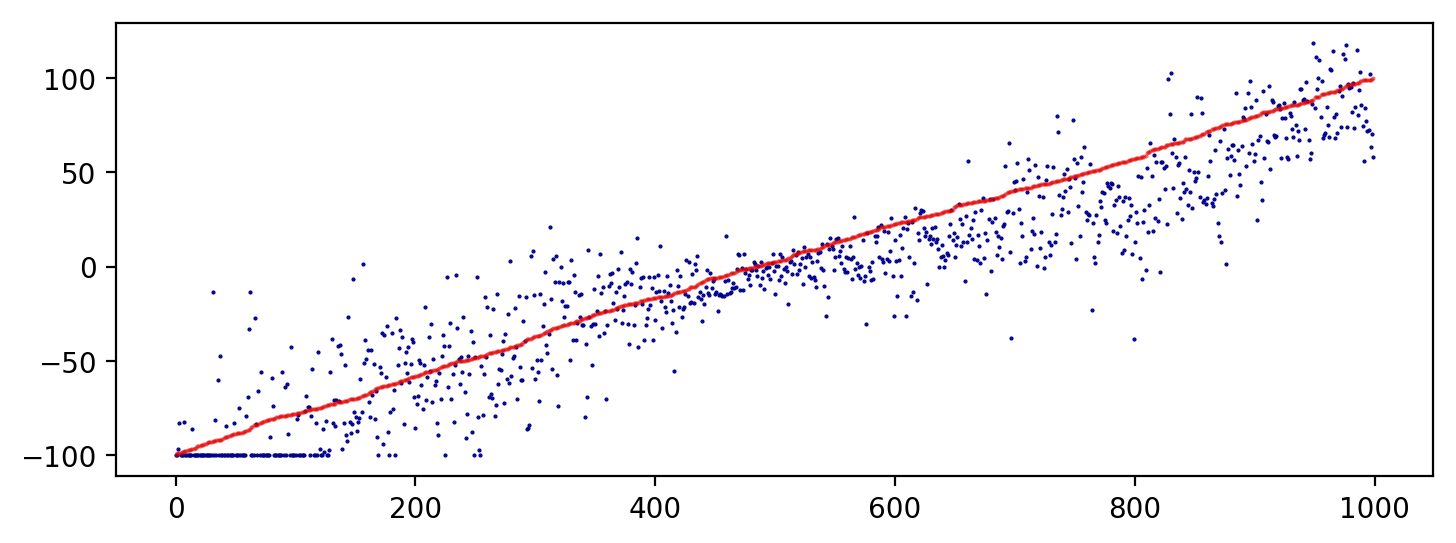

 epoch:  115 batch: 499
 epoch:  116 batch: 499st: 0.0078784348
 epoch:  117 batch: 499st: 0.0096929278
 epoch:  118 batch: 499st: 0.0075772400
 epoch:  119 batch: 499st: 0.0083797378
 epoch:  119 testing_cost: 0.0072489134

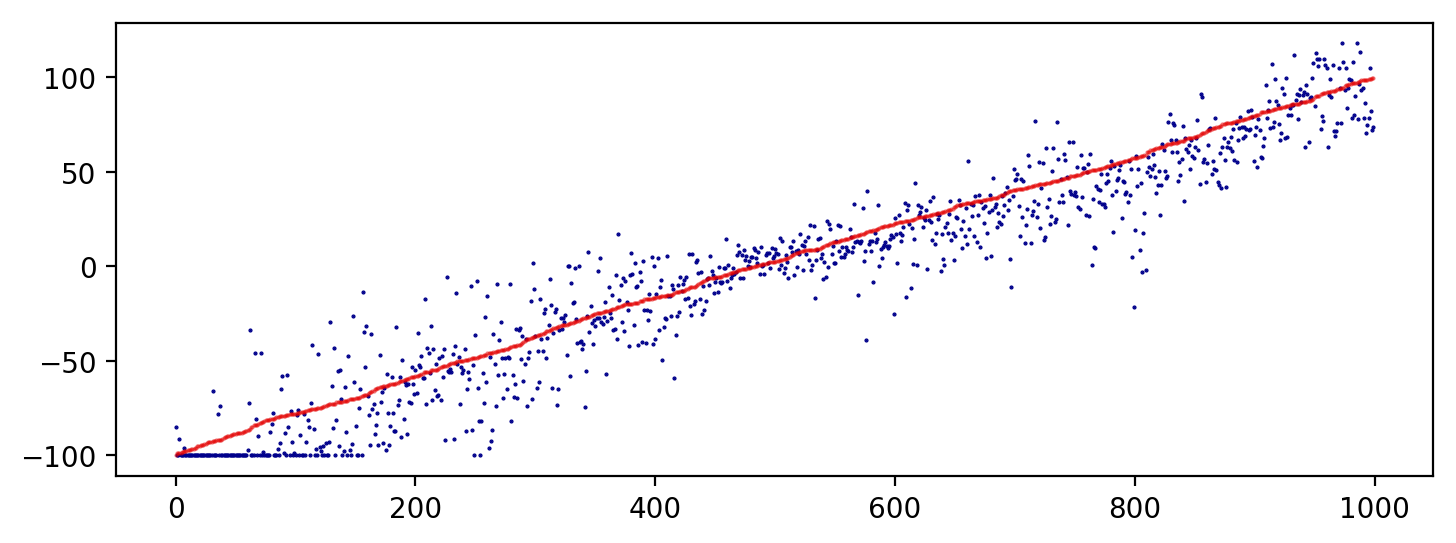

 epoch:  120 batch: 499
 epoch:  121 batch: 499st: 0.0080202119
 epoch:  122 batch: 499st: 0.0080919443
 epoch:  123 batch: 499st: 0.0066345688
 epoch:  124 batch: 499st: 0.0066356366
 epoch:  124 testing_cost: 0.0062411600

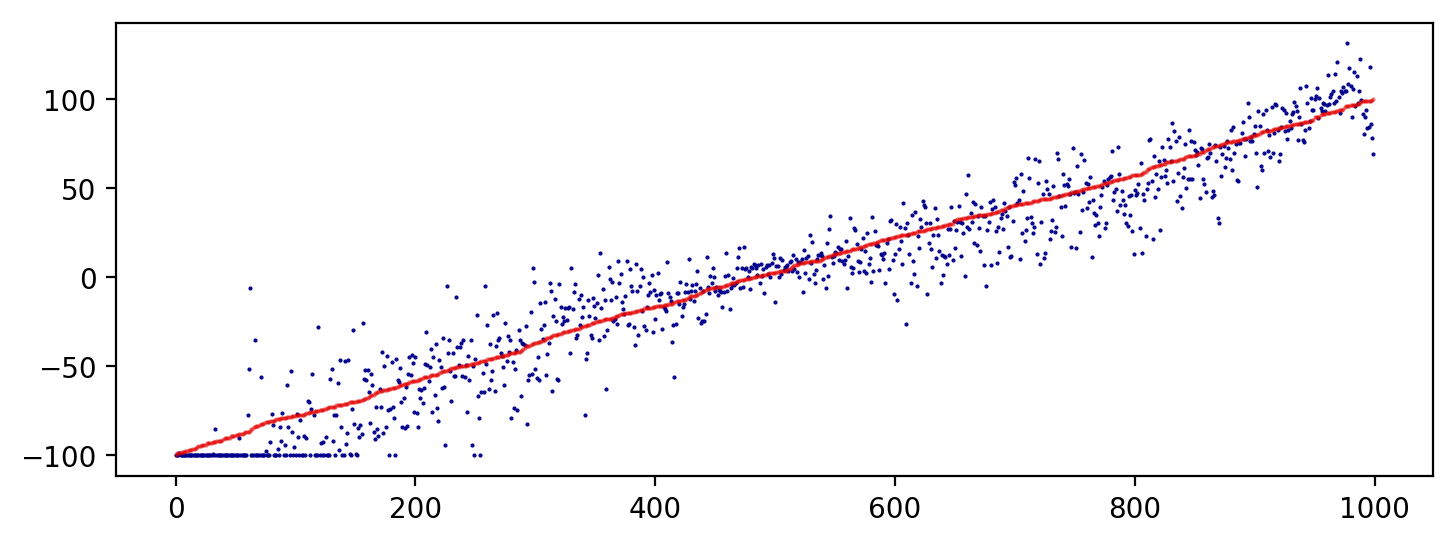

 epoch:  125 batch: 499
 epoch:  126 batch: 499st: 0.0057329508
 epoch:  127 batch: 499st: 0.0047737150
 epoch:  128 batch: 499st: 0.0054039662
 epoch:  129 batch: 499st: 0.0046587419
 epoch:  129 testing_cost: 0.0048380960

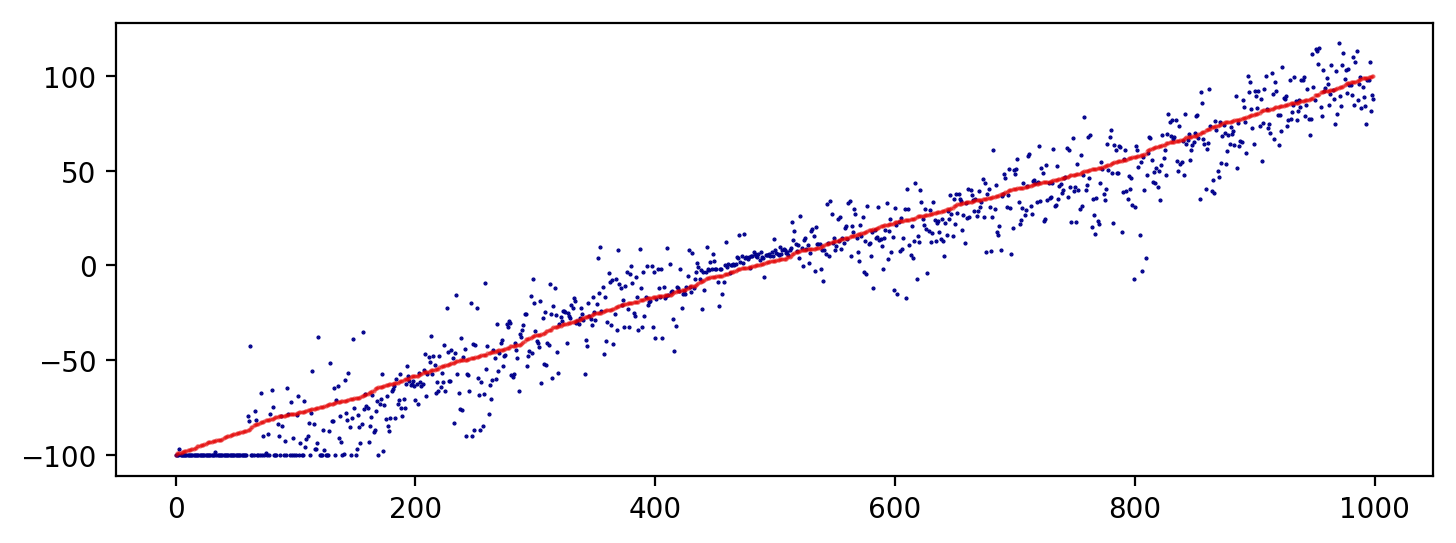

 epoch:  130 batch: 499
 epoch:  131 batch: 499st: 0.0048562763
 epoch:  132 batch: 499st: 0.0045268000
 epoch:  133 batch: 499st: 0.0042452361
 epoch:  134 batch: 499st: 0.0048666485
 epoch:  134 testing_cost: 0.0049989466

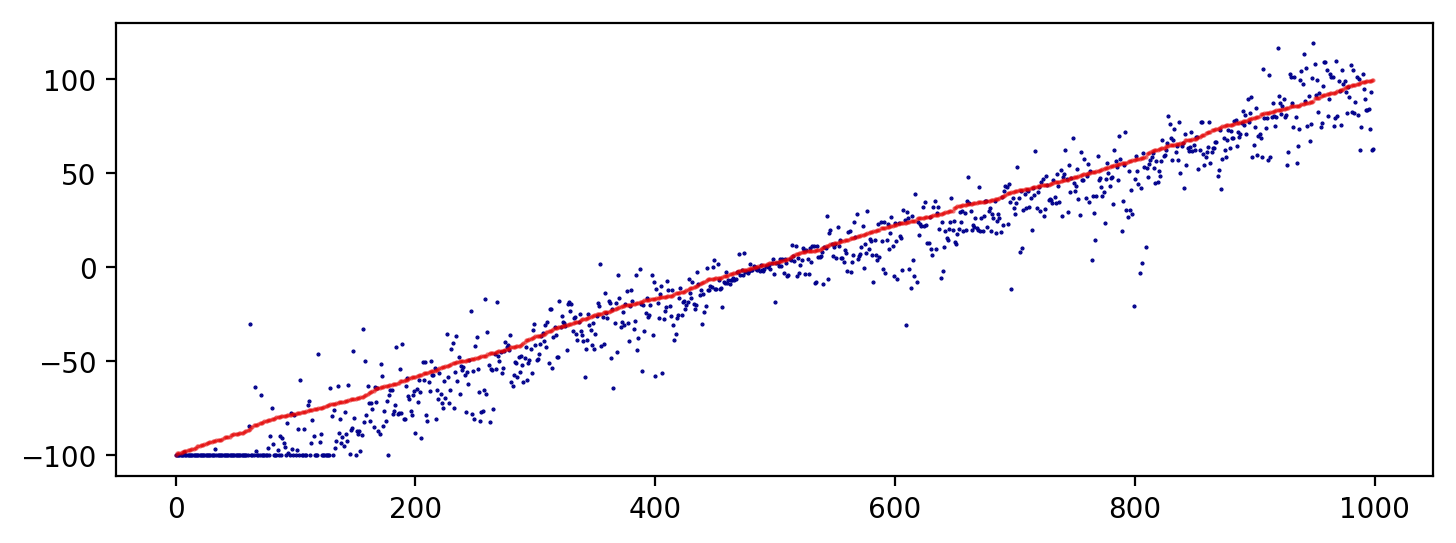

 epoch:  135 batch: 499
 epoch:  136 batch: 499st: 0.0032474890
 epoch:  137 batch: 499st: 0.0052319719
 epoch:  138 batch: 499st: 0.0037929290
 epoch:  139 batch: 499st: 0.0039101196
 epoch:  139 testing_cost: 0.0037267322

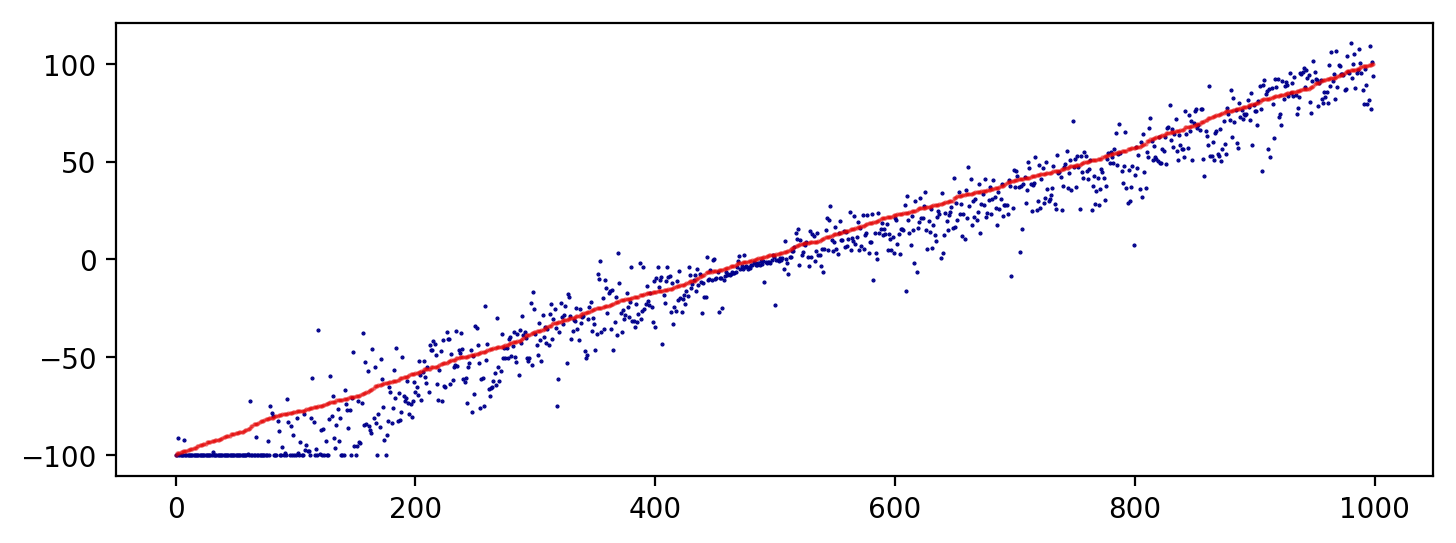

 epoch:  140 batch: 499
 epoch:  141 batch: 499st: 0.0040104701
 epoch:  142 batch: 499st: 0.0039670235
 epoch:  143 batch: 499st: 0.0035645643
 epoch:  144 batch: 499st: 0.0032720924
 epoch:  144 testing_cost: 0.0026881152

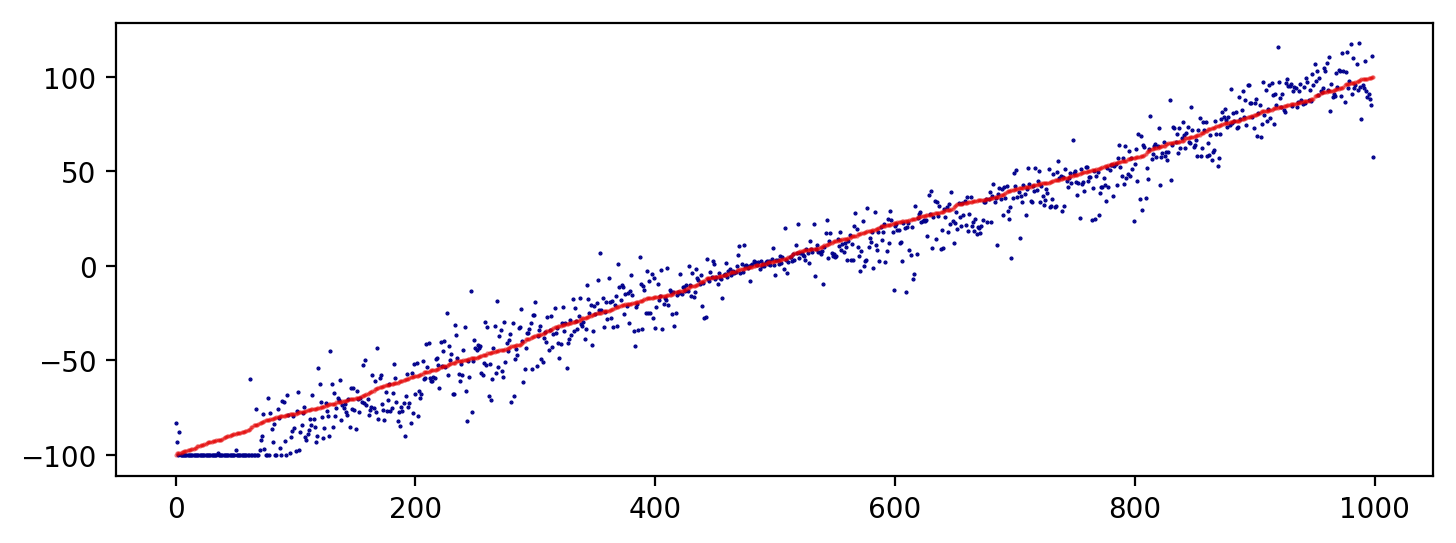

 epoch:  145 batch: 499
 epoch:  146 batch: 499st: 0.0032610528
 epoch:  147 batch: 499st: 0.0034292061
 epoch:  148 batch: 499st: 0.0025505205
 epoch:  149 batch: 499st: 0.0031295773
 epoch:  149 testing_cost: 0.0035737853

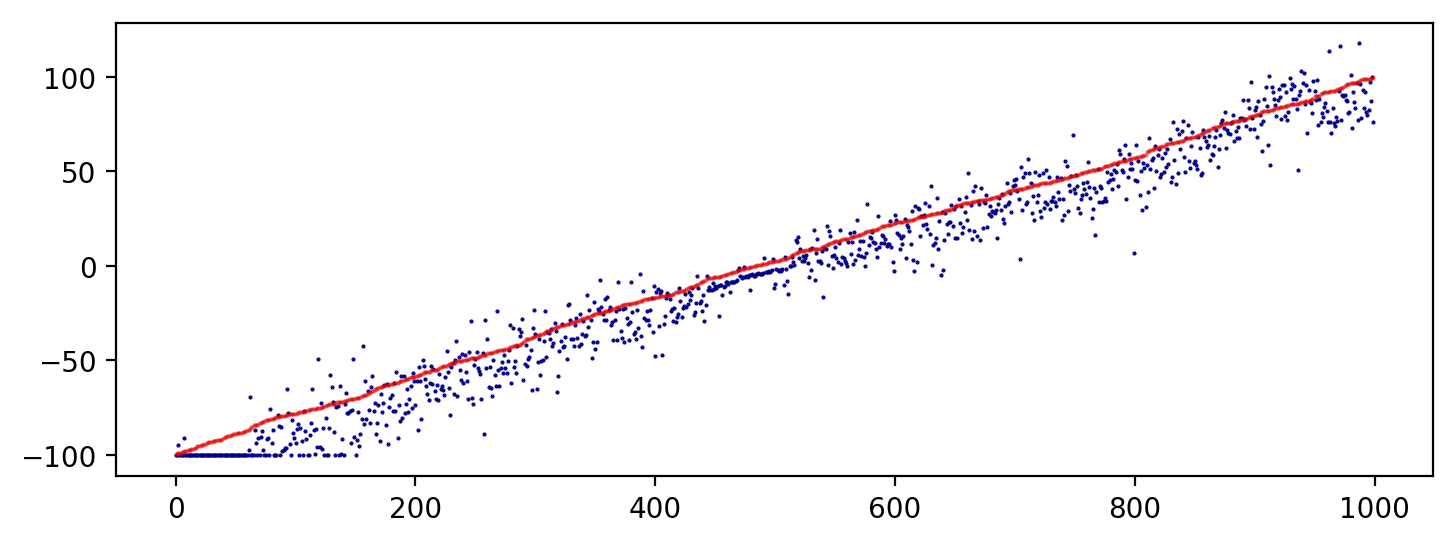

 epoch:  150 batch: 499
 epoch:  151 batch: 499st: 0.0032741958
 epoch:  152 batch: 499st: 0.0032950102
 epoch:  153 batch: 499st: 0.0031977736
 epoch:  154 batch: 499st: 0.0035061636
 epoch:  154 testing_cost: 0.0023525232

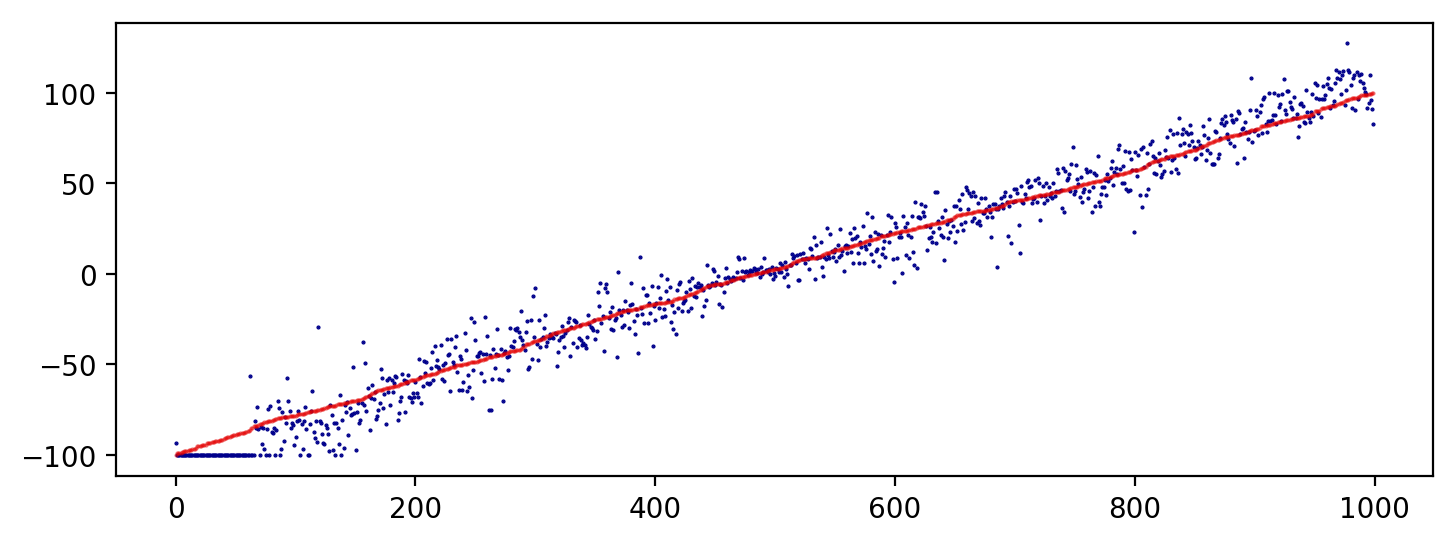

 epoch:  155 batch: 499
 epoch:  156 batch: 499st: 0.0026435223
 epoch:  157 batch: 499st: 0.0026600785
 epoch:  158 batch: 499st: 0.0028822031
 epoch:  159 batch: 499st: 0.0029326007
 epoch:  159 testing_cost: 0.0031017652

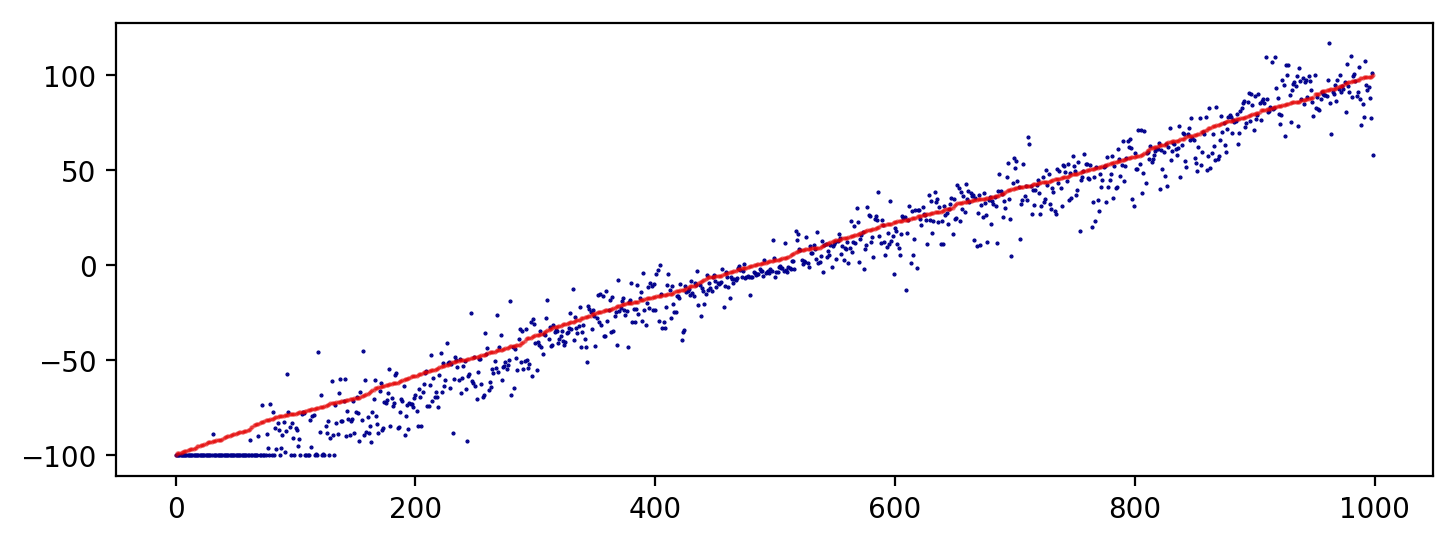

 epoch:  160 batch: 499
 epoch:  161 batch: 499st: 0.0020931931
 epoch:  162 batch: 499st: 0.0027358832
 epoch:  163 batch: 499st: 0.0023021125
 epoch:  164 batch: 499st: 0.0024496450
 epoch:  164 testing_cost: 0.0020001172

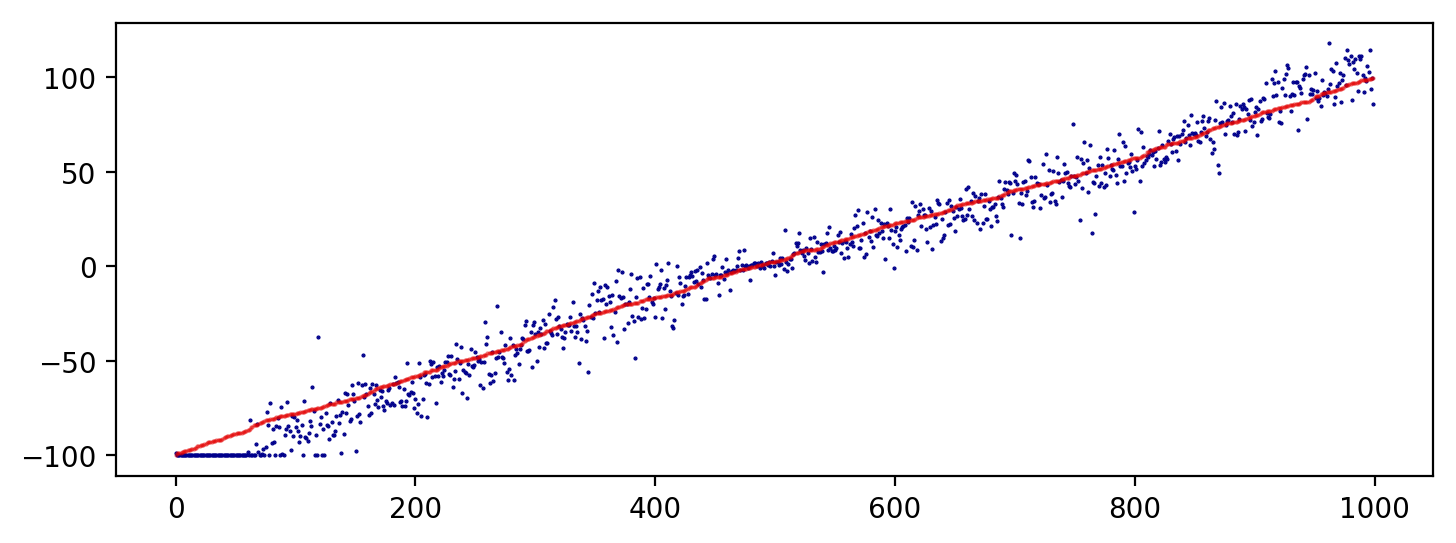

 epoch:  165 batch: 499
 epoch:  166 batch: 499st: 0.0020790691
 epoch:  167 batch: 499st: 0.0023933081
 epoch:  168 batch: 499st: 0.0023748975
 epoch:  169 batch: 499st: 0.0025511156
 epoch:  169 testing_cost: 0.0020532748

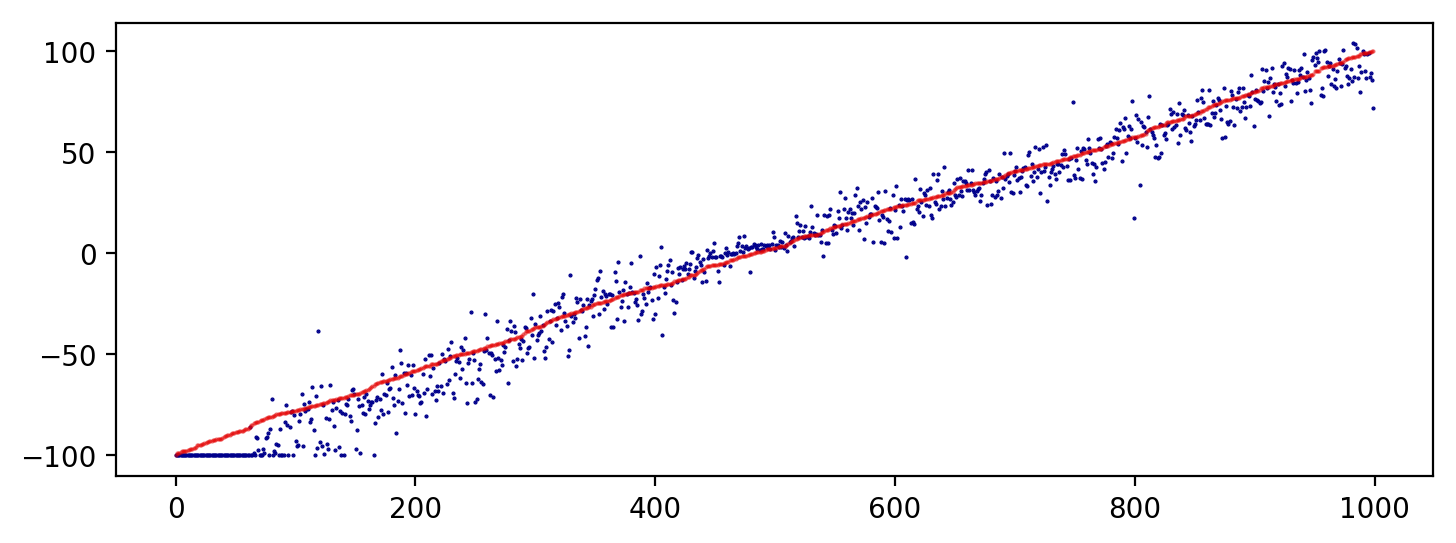

 epoch:  170 batch: 499
 epoch:  171 batch: 499st: 0.0022082448
 epoch:  172 batch: 499st: 0.0028113220
 epoch:  173 batch: 499st: 0.0019727952
 epoch:  174 batch: 499st: 0.0019585858
 epoch:  174 testing_cost: 0.0020316734

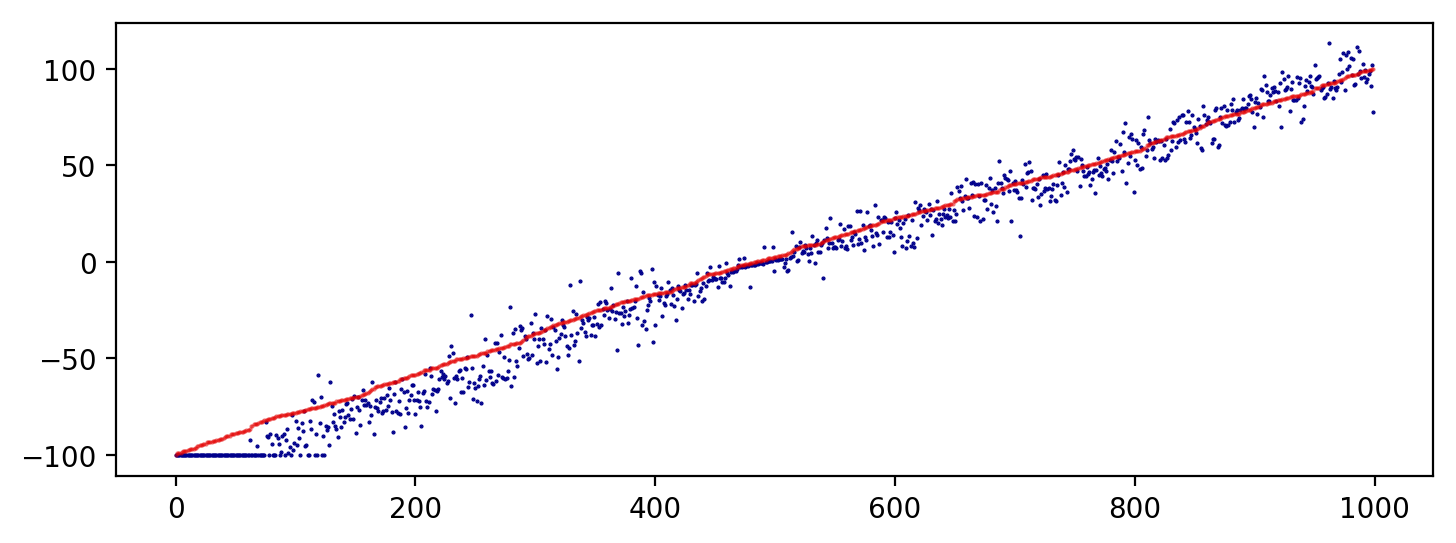

 epoch:  175 batch: 499
 epoch:  176 batch: 499st: 0.0018442096
 epoch:  177 batch: 499st: 0.0018722320
 epoch:  178 batch: 499st: 0.0023210016
 epoch:  179 batch: 499st: 0.0029358284
 epoch:  179 testing_cost: 0.0015818556

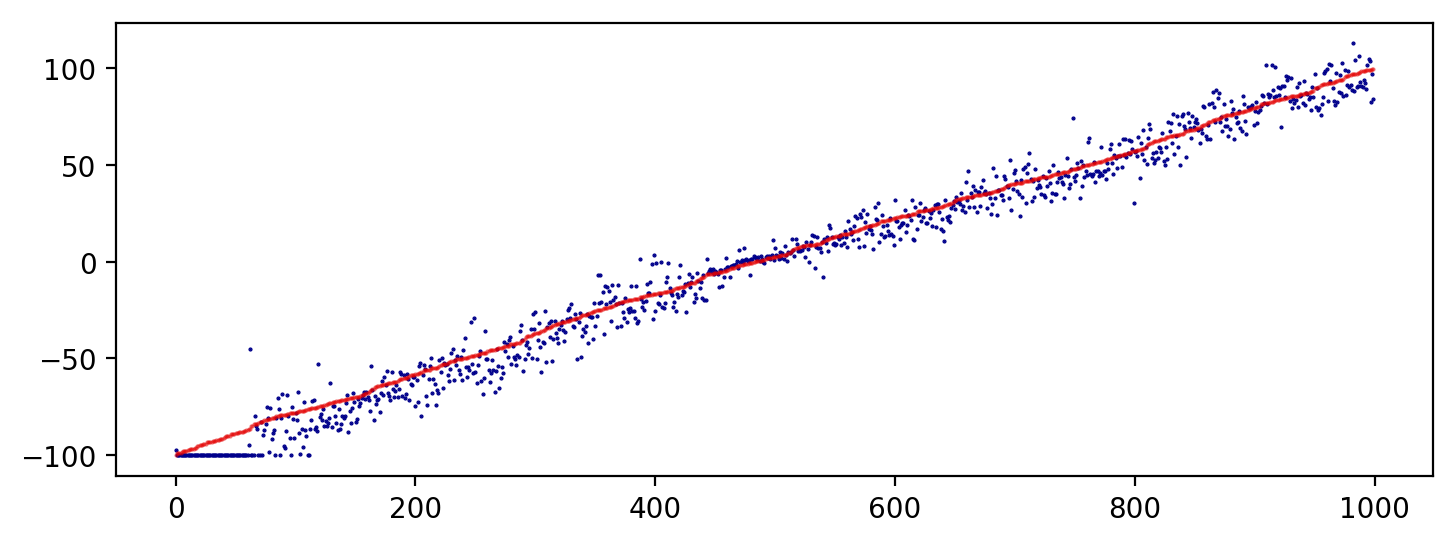

 epoch:  180 batch: 499
 epoch:  181 batch: 499st: 0.0017827969
 epoch:  182 batch: 499st: 0.0018659784
 epoch:  183 batch: 499st: 0.0019557853
 epoch:  184 batch: 499st: 0.0015987771
 epoch:  184 testing_cost: 0.0017113704

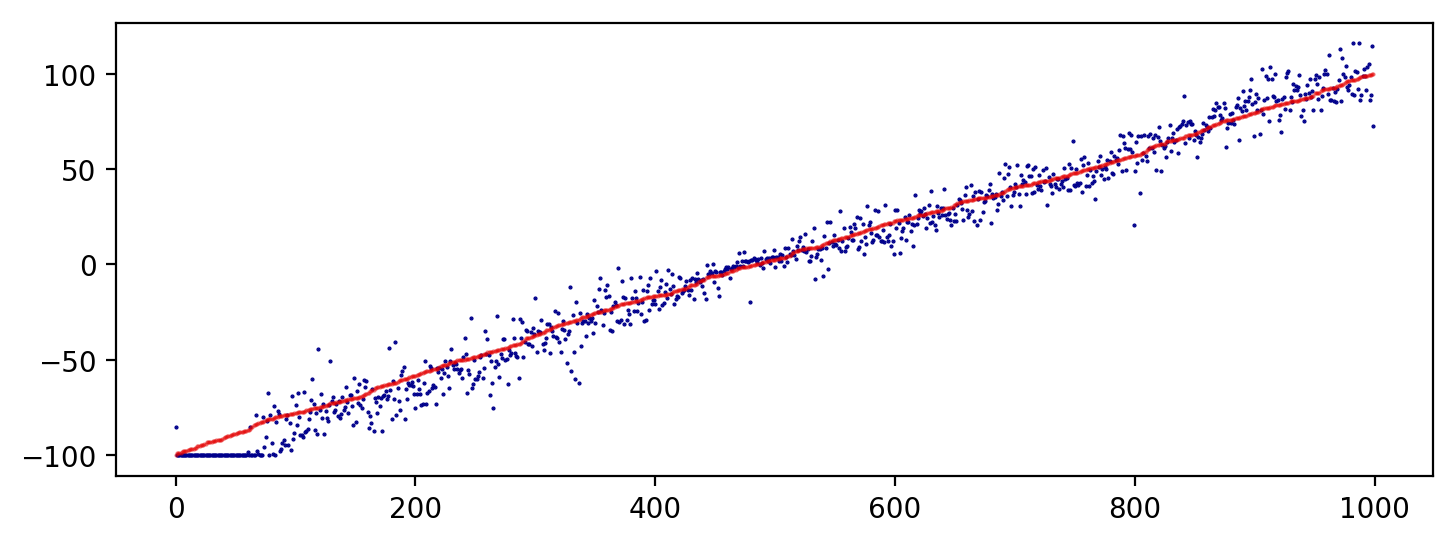

 epoch:  185 batch: 499
 epoch:  186 batch: 499st: 0.0017696412
 epoch:  187 batch: 499st: 0.0019785280
 epoch:  188 batch: 499st: 0.0015846897
 epoch:  189 batch: 499st: 0.0017837719
 epoch:  189 testing_cost: 0.0015900240

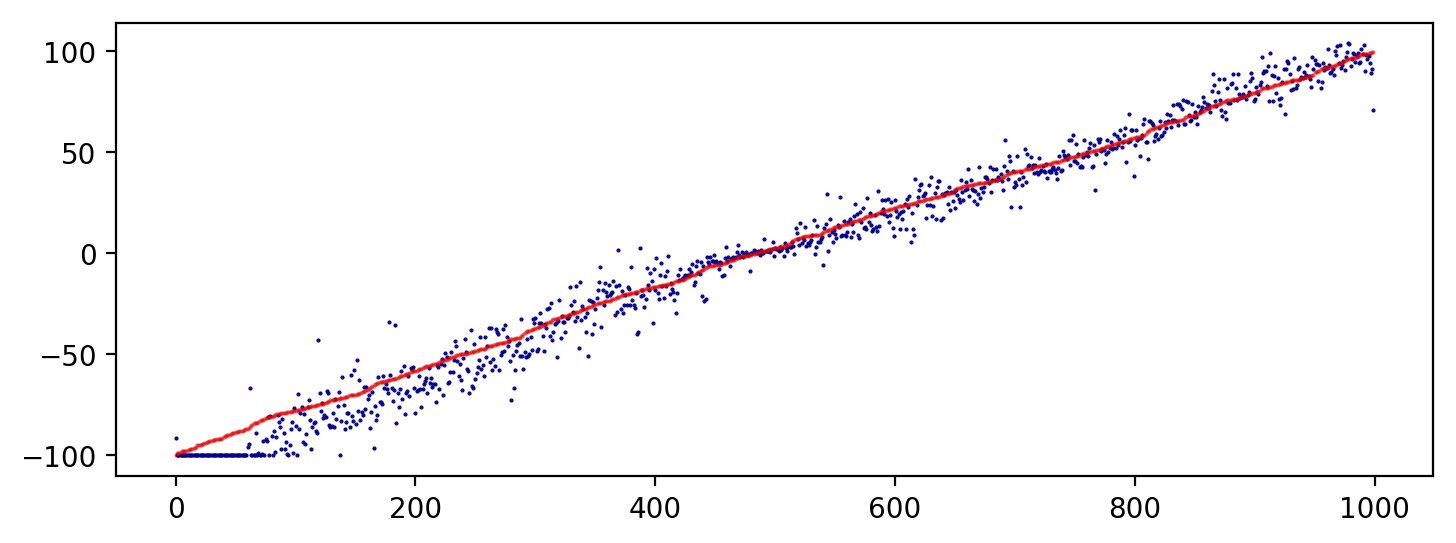

 epoch:  190 batch: 499
 epoch:  191 batch: 499st: 0.0014168655
 epoch:  192 batch: 499st: 0.0016365520
 epoch:  193 batch: 499st: 0.0016386495
 epoch:  194 batch: 499st: 0.0020610972
 epoch:  194 testing_cost: 0.0014345836

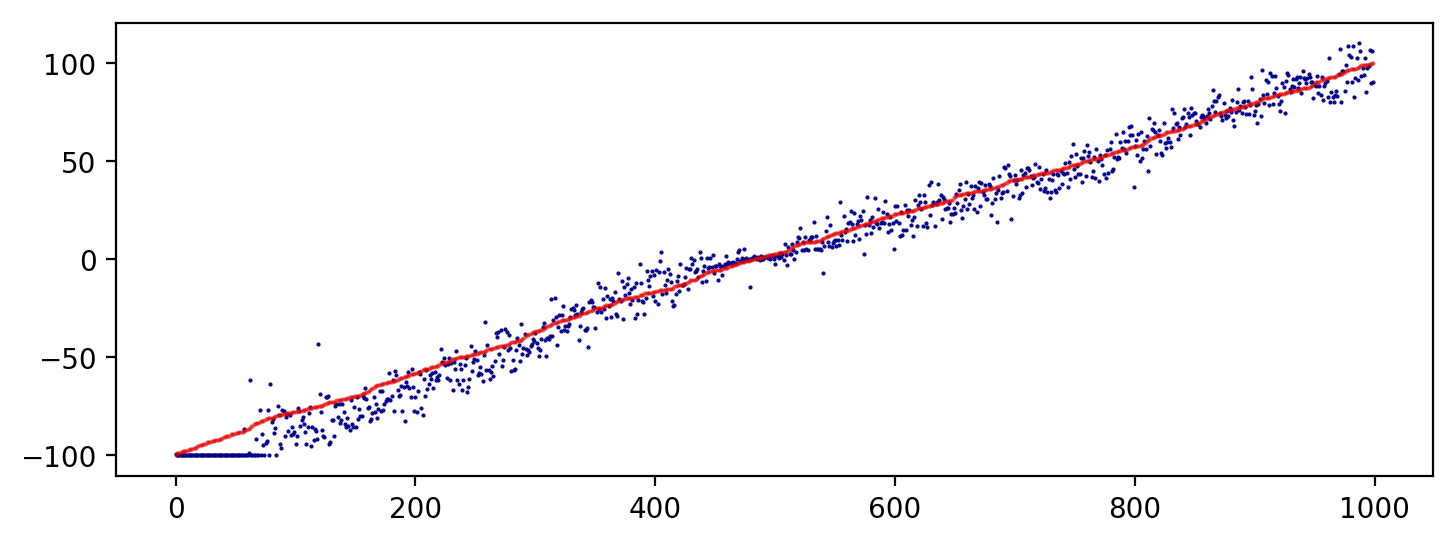

 epoch:  195 batch: 499
 epoch:  196 batch: 499st: 0.0014982577
 epoch:  197 batch: 499st: 0.0018859387
 epoch:  198 batch: 499st: 0.0015130002
 epoch:  199 batch: 499st: 0.0021299715
 epoch:  199 testing_cost: 0.0015876921

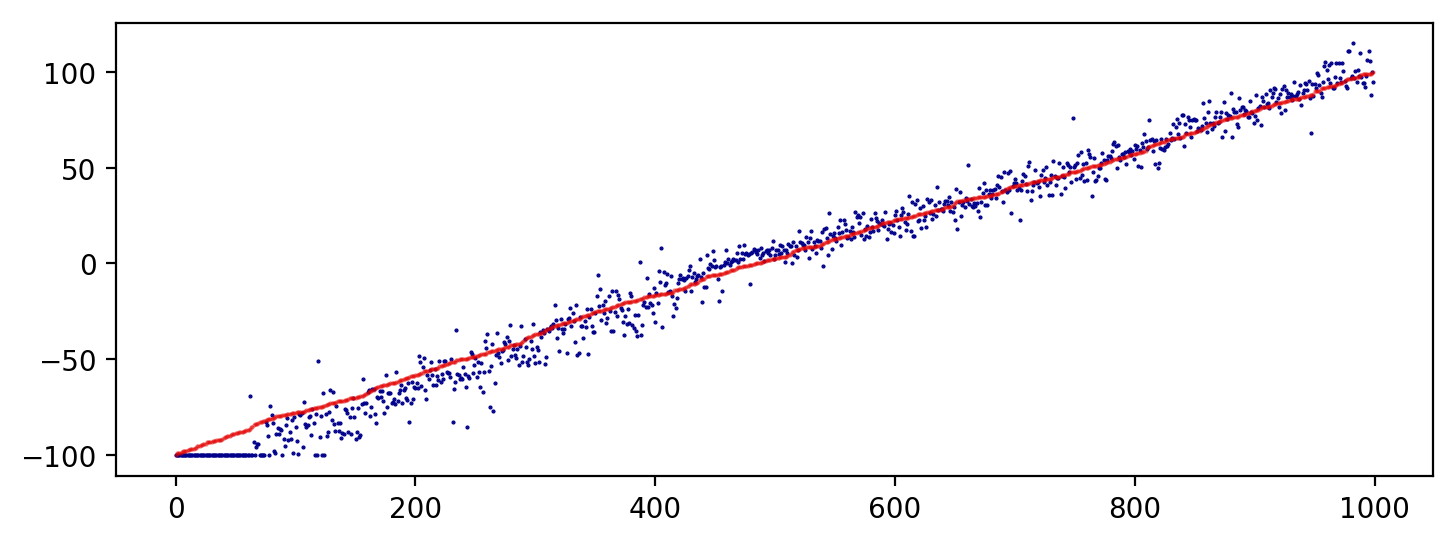

In [22]:
with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/trained_model.ckpt'


    for epoch in range(FLAGS.num_epochs):
        
        split_permutation = np.random.permutation(X_train.shape[0])
        X_train_batches = np.vsplit(X_train[split_permutation], 500)
        y_train_batches = np.vsplit(y_train[split_permutation], 500)
        
        for i in range(500):
            X_train_batch = X_train_batches[i]
            y_train_batch = y_train_batches[i]
            sys.stdout.write('\r epoch: {:4.0f} batch: {:3.0f}'.format(epoch, i))
            session.run(optimizer,
                        feed_dict = {X: X_train_batch, y: y_train_batch, keep_prob : 0.50})

        
        training_feed = {X: X_train, y: y_train, keep_prob : 1.00}
        training_cost, training_summary = session.run([cost, summary], feed_dict = training_feed)

        
        testing_feed =  {X: X_test, y: y_test, keep_prob : 1.00}
        testing_cost, testing_summary = session.run([cost, summary],feed_dict = testing_feed)
        
        sys.stdout.write('\n\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, testing_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if (epoch + 1) % 5 == 0:
            
            saver.save(session, model_save_location, epoch)
            prediction_scaled = session.run(prediction, feed_dict = {X: X_test, keep_prob : 1.00})
            
            prediction_unscaled = output_scaler.inverse_transform(prediction_scaled)
            actual_unscaled = output_scaler.inverse_transform(y_test)
            
            sorting_idx = np.argsort(actual_unscaled.T[0])
            fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
            
            ax.plot(prediction_unscaled.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, color = 'darkblue')
            ax.plot(actual_unscaled.T[0][sorting_idx],     linestyle = 'none', marker = '.', markersize = 1, color = '#E50000', alpha = 0.50, )
            plt.show()
            
    saver.save(session, model_save_location, epoch)